# Class 2: Regression Models
by Cory Lanker, LLNL statistician

June 27, 2017, 10:00-11:30 in B543 R1001

This course is a four-class introduction to predictive modeling. It is for all skill levels and will use R statistics software. But as the course is presented with R notebooks, all the code is here. In this class, I'll discuss the different prediction models and how to code them in R. Tomorrow (***at 2:00***) we'll discuss the categorical response parallel to today's material: classification. The last class (Thurs) is a prediction contest where teams will use this material in a competition to get the best prediction values.

See the Class 1 notes for assistance installing Jupyter and Anaconda.

In this class:

* Linear Regression: regression assessment and linear regression models
* Nonlinear Regression: a survey of nonlinear regression models in R
* Regression Trees: tree regression models including random forests and boosted trees
* Example Data Set: comparing the various regression models when predicting concrete performance

This work performed under the auspices of the U.S. Department of Energy 
by Lawrence Livermore National Laboratory under Contract DE-AC52-07NA27344.
LLNL-PRES-733567

## References for the course

This course is structured around Max Kuhn and Kjell Johnson's master's-level 
text on prediction modeling. The code is either from the book, especially when
using their wonderful `caret` R package, or it's code I wrote. Their code is
disseminated under their copyright. All data sets in this course are all publicly available.

### Copyright for code by Kuhn and Johnson 

- R code from Applied Predictive Modeling (2013) by Kuhn and Johnson.
- Copyright 2013 Kuhn and Johnson and is covered under the General Public License:
    * https://www.gnu.org/licenses/gpl-3.0.en.html
- Web Page: http://www.appliedpredictivemodeling.com
- Contact: Max Kuhn (mxkuhn@gmail.com)
- Kuhn and Johnson code will be denoted throughout the course with (C) Kuhn and Johnson, 2013

### References

1. Breiman, Leo. "Statistical modeling: The two cultures." Statistical science 16.3 (2001): 199-231.
* Clarke, Bertrand, Ernest Fokoue, and Hao Helen Zhang. Principles and theory for data mining and machine learning. New York: Springer, 2009.
* Friedman, Jerome, Trevor Hastie, and Robert Tibshirani. The elements of statistical learning. New York: Springer, 2001.
* James, Gareth, et al. An introduction to statistical learning. New York: Springer, 2013.
* Kuhn, Max, and Kjell Johnson. Applied predictive modeling. New York: Springer, 2013.
* Venables, William N., and Brian D. Ripley. Modern applied statistics with S. New York: Springer, 2002.


### Source functions and install libraries

In [1]:
# functions for this page
plotsize <- function(wd,ht){options(repr.plot.width=wd, repr.plot.height=ht)}
packagelist <- c("MASS", "FNN", "ellipse", "AppliedPredictiveModeling", "Hmisc", 
                 "missForest", "caret", "corrplot", "earth", "lattice", "e1071",
                 "elasticnet", "pls", "doMC", "kernlab", "nnet", "rpart", "ipred",
                 "Cubist", "gbm", "party", "partykit", "randomForest", "car",
                 "plyr", "proxy", "RWeka")
# It's likely that RWeka won't load on LLNL machines... that package isn't necessary.
output <- sapply(packagelist, require, character.only = TRUE)
if (any(!output)){
    cat('Installing packages: ', packagelist[!output],' ...\n')
    install.packages(packagelist[!output])
    output <- sapply(packagelist[!output], require, character.only = TRUE)
}
# sessionInfo()

Loading required package: MASS
Loading required package: FNN
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘FNN’”Loading required package: ellipse
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘ellipse’”Loading required package: AppliedPredictiveModeling
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘AppliedPredictiveModeling’”Loading required package: Hmisc
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘Hmisc’”Loading required package: missForest
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘missForest’”Loading required package: caret
Loading required package: lattic

Installing packages:  FNN ellipse AppliedPredictiveModeling Hmisc missForest corrplot earth e1071 elasticnet pls doMC kernlab ipred Cubist gbm party partykit proxy RWeka  ...


also installing the dependencies ‘numDeriv’, ‘TH.data’, ‘checkmate’, ‘htmlwidgets’, ‘viridisLite’, ‘plotrix’, ‘lava’, ‘multcomp’, ‘CORElearn’, ‘Formula’, ‘latticeExtra’, ‘acepack’, ‘gridExtra’, ‘data.table’, ‘htmlTable’, ‘viridis’, ‘itertools’, ‘plotmo’, ‘TeachingDemos’, ‘lars’, ‘prodlim’, ‘mvtnorm’, ‘modeltools’, ‘strucchange’, ‘coin’, ‘sandwich’, ‘RWekajars’, ‘rJava’

Warning message in install.packages(packagelist[!output]):
“installation of package ‘rJava’ had non-zero exit status”Warning message in install.packages(packagelist[!output]):
“installation of package ‘RWekajars’ had non-zero exit status”Warning message in install.packages(packagelist[!output]):
“installation of package ‘RWeka’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: FNN
Loading required package: ellipse

Attaching package: ‘ellipse’

The following object is masked from ‘package:car’:

    ellipse

Loading required package: AppliedP

# Part 5. Assessing regression models



A common metric to assess performance of a regression model (predicts continuous $y$)
is to calculate the mean squared error (MSE) between the predictions and the true values:
$$MSE = \frac1n\sum_{i=1}^n (\hat{y}_i - y_i)^2.$$

MSE penalizes errors according to the square of the deviation. This means if you are off by 0.1 for each of 100 observations, you have the same MSE if you get 99 exactly correct but off by 1 on the remaining observation:
$$\frac1{100} \sum_{i=1}^{100} (0.1)^2 = \frac1{100}\, (100)(.01)
= \frac1{100} \left( \sum_{i=1}^{99} (0)^2 + \sum_{i=100}^{100} (1)^2\right).$$
The average absolute error or AAE ($\sum |\hat{y}-y|$) is 0.1 and 0.01, respectively, but the MSE is the same.

The optimizer for MSE is to predict the expected mean $E(Y|X)$, while the optimizer for
AAE is to predict the expected median of the distribution

- if you're not at the median, then you can reduce AAE by moving towards the more populated side

MSE is often reported using its square root, RMSE.


## Solubility data

This class will use a data set on solubility data. A drug's solubility plays a factor in whether medications can be administered orally. The data set consists of 1267 compounds and 

In [3]:
### R code from Applied Predictive Modeling (2013) by Kuhn and Johnson.
### Copyright 2013 Kuhn and Johnson
### Web Page: http://www.appliedpredictivemodeling.com
### Contact: Max Kuhn (mxkuhn@gmail.com)
###
### Chapter 6: Linear Regression and Its Cousins
###
### Required packages: AppliedPredictiveModeling, lattice, corrplot, pls, 
###                    elasticnet,
###
### Data used: The solubility from the AppliedPredictiveModeling package

plotsize(6,3)
data(solubility)
cat(dim(solTrainX),"::",length(solTrainY),"::",dim(solTestX),"::",length(solTestY),'\n')

951 228 :: 951 :: 316 228 :: 316 


In [8]:
?col

In [4]:
col.factor = sapply(solTrainX[1,],is.factor)
table(col.factor)
plotsize(6,3)
col.unique = sapply(apply(solTrainX,2,unique),length)
cat('There are', min(which(col.unique > 2))-1,'binary predictors (fingerprints). The rest are called descriptors.')

col.factor
FALSE 
  228 

There are 208 binary predictors (fingerprints). The rest are called descriptors.

The other 20 predictors are descriptors: 16 count variables (e.g., number of bond types or certain atoms)
and 4 continuous predictors.

In [226]:
tabulate(colSums(is.na(rbind(solTrainX, solTestX))))
sum(is.na(solTrainY))
sum(col.unique[1:208] != 2)

[1] 0

[1] 0

[1] 0

[1] 0.03785489

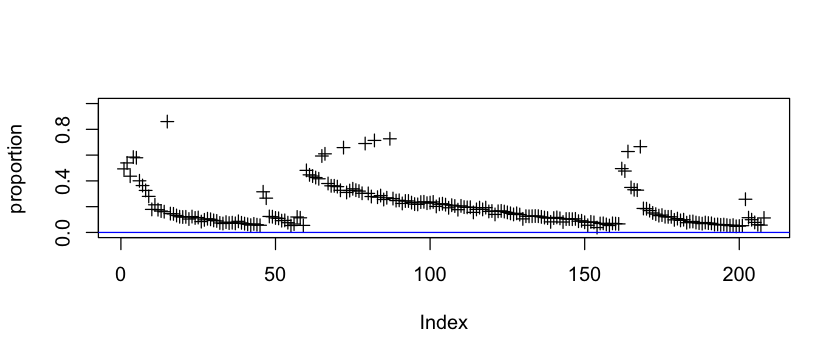

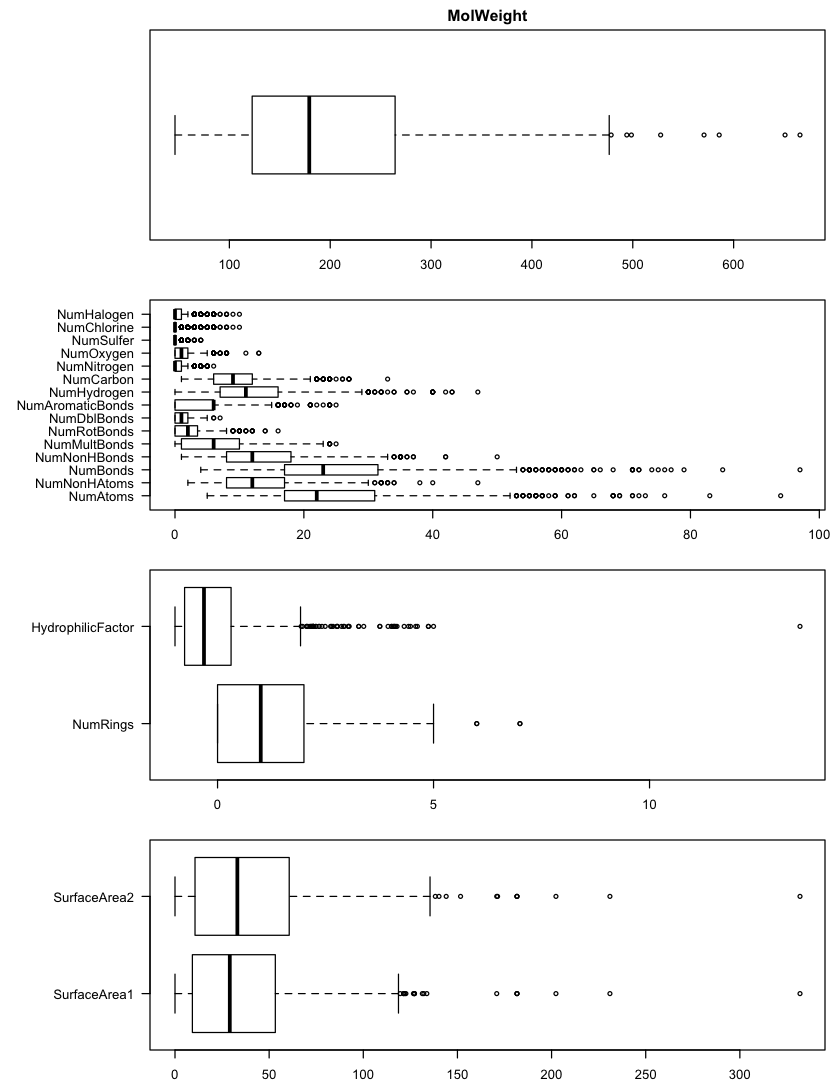

In [227]:
plotsize(7,3)
plot(temp <- colMeans(solTrainX[,1:208]),ylab='proportion',ylim=c(0,1),pch=3)
min(temp)
abline(h=0,col='blue')
plotsize(7,9)
par(mfrow=c(4,1), las=1, mai=c(.25,1.25,.25,.125))
boxplot(solTrainX[,209], horizontal=T, main=colnames(solTrainX)[209])
boxplot(solTrainX[,210:224], horizontal=T)
boxplot(solTrainX[,225:226], horizontal=T)
boxplot(solTrainX[,227:228], horizontal=T)

In [228]:
head(solTrainX[,209:228])

MolWeight NumAtoms NumNonHAtoms NumBonds NumNonHBonds NumMultBonds
661 208.28    28       16           30       18           16          
662 365.54    49       26           52       29           13          
663 206.31    33       15           33       15            7          
665 136.26    26       10           26       10            2          
668 229.75    31       15           31       15            6          
669 270.25    32       15           31       14            2          
    NumRotBonds NumDblBonds NumAromaticBonds NumHydrogen NumCarbon NumNitrogen
661 0           0           16               12          14        2          
662 4           0           12               23          21        3          
663 4           1            6               18          13        0          
665 1           2            0               16          10        0          
668 5           0            6               16           9        5          
669 5           2            0               17          10        1          
    NumOxygen NumSulfer NumChlorine NumHalogen NumRings HydrophilicFactor
661 0         0         0           0          3        -0.856           
662 1         1         0           0          4        -0.370           
663 2         0         0           0          1        -0.330           
665 0         0         0           0          1        -0.960           
668 0         0         1           1          1        -0.069           
669 1         1         2           2          0        -0.651           
    SurfaceArea1 SurfaceArea2
661 25.78        25.78       
662 52.19        80.43       
663 37.30        37.30       
665  0.00         0.00       
668 53.94        53.94       
669 20.31        45.61

Columns 1-208 are binary 0/1, Columns 209 (MolWt), 226:228 (Hydro, SA1, SA2) are continuous, Columns 210:225 are 16 count descriptors.

## Constant prediction (MSE and AAE minimizers)

Let $y$ be $\log(\text{solubility})$. The range, mean, and median are, with a boxplot:

In [229]:
y = solTrainY
cat("range=",range(y)," mean=",mean(y)," median=",median(y))

range= -11.62 1.58  mean= -2.71857  median= -2.51

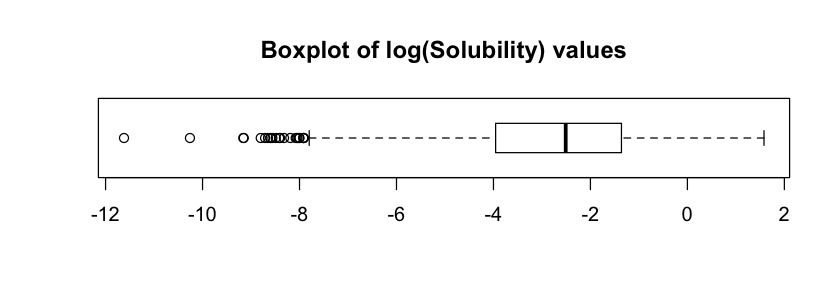

In [230]:
plotsize(7,2.5)
boxplot(solTrainY, horizontal=TRUE, main="Boxplot of log(Solubility) values")

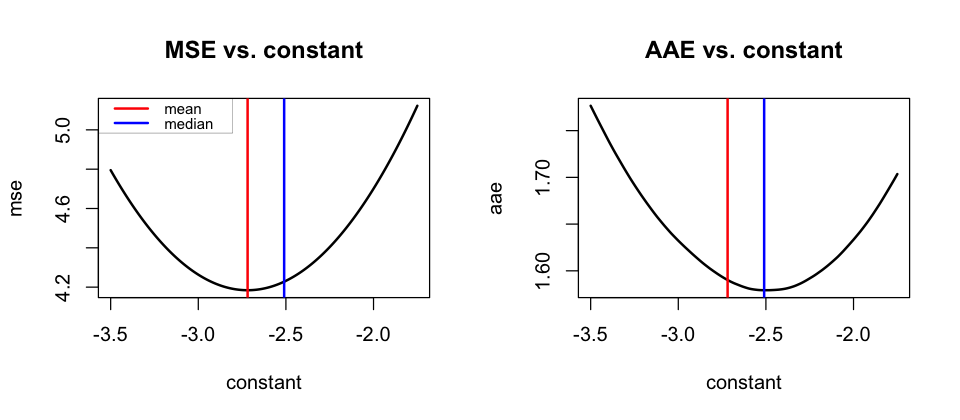

In [231]:
# show plot of MSE versus constant value, and minimum at mean(Y)
xs = seq(-3.5,-1.75,,176)
mse = sapply(xs, function(x) (1/length(y))*sum((y - x)^2))
# show plot of AAE versus constant value, and minimum at median(Y)
aae = sapply(xs, function(x) (1/length(y))*sum(abs(y-x)))
plotsize(8,3.5)
par(mfrow=c(1,2))
plot(xs,mse,type='l',lwd=2,main='MSE vs. constant',xlab='constant')
abline(v=mean(y),col='red',lwd=2)
abline(v=median(y),col='blue',lwd=2)
legend('topleft',c('mean','median'),lwd=2,col=c(2,4),cex=.75,y.intersp=2.5,box.lwd=.25)
plot(xs,aae,type='l',lwd=2,main='AAE vs. constant',xlab='constant')
abline(v=mean(y),col='red',lwd=2)
abline(v=median(y),col='blue',lwd=2)
    

In [232]:
# show RMSE calculation using mean value
cat("The best training RMSE using a constant prediction value is",
   rmse <- sqrt( (1/length(y))*sum((y-mean(y))^2)))

The best training RMSE using a constant prediction value is 2.045565

We may get a sense about RMSE if we show the median $\pm$ RMSE on the boxplot of log(Solubility) values:

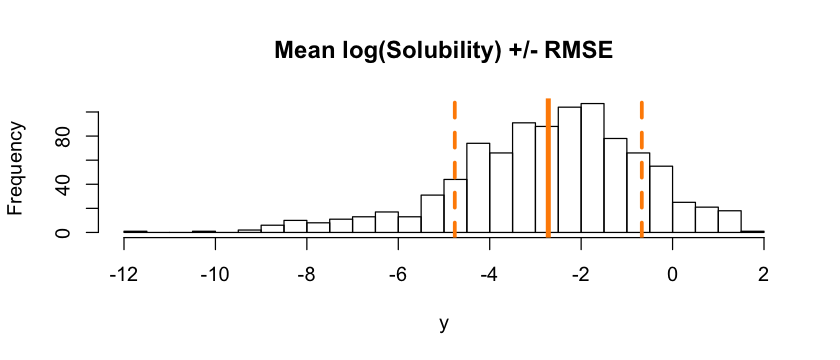

In [233]:
plotsize(7,3)
hist(y, 30, main="Mean log(Solubility) +/- RMSE")
abline(v=mean(y),lwd=4,col='darkorange')
abline(v=mean(y)+c(-1,1)*rmse,lwd=3,lty=2,col='darkorange')

## Pausing to consider our goal

Our goal is to predict solubility (continuous) based on the information in the 208 binary/16 count/4 continuous predictors. Only a minuscule portion of the predictor space is populated with our $\mathbf{X}$ observations, and
it's only at those locations that we know a $y$. How to find a function of $\mathbf{X}$ approximating $E(y|X)$ (thus minimizing the mean squared error) given such limited data?

### Considering the space $\{0,1\}^{208}$

There are $2^{208}$ or $4.1 \times 10^{62}$ possible arrangements of these 208 binary variables.

Modeling will only work if there are strong influences on $y$ from the individual values and can consider the predictors separately. 
There are only $2^{208}$ possibilities of how $y$ is affected if each 208-level interaction is important.

For example, we could have a case of two binary predictors such if $x_1$ or $x_2$ is one, $y$ is likely to be high,
if $x_1$ and $x_2$ are both zero, then $y$ takes a low value. In this case, there isn't an interaction effect between $x_1$ and $x_2$ so we can consider the variables separately when forming a prediction for $y$. However,
if in addition, when $x_1$ and $x_2$ are both one then $y$ is low, now we must consider all four possibilities of the $x_1, x_2$ space.

72 0.3366402

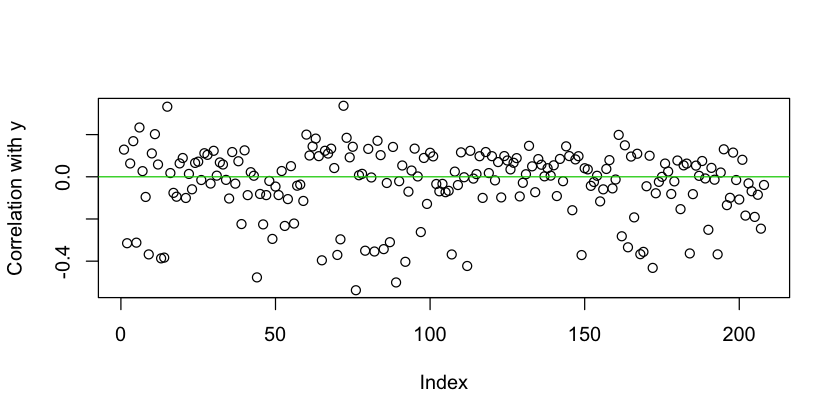

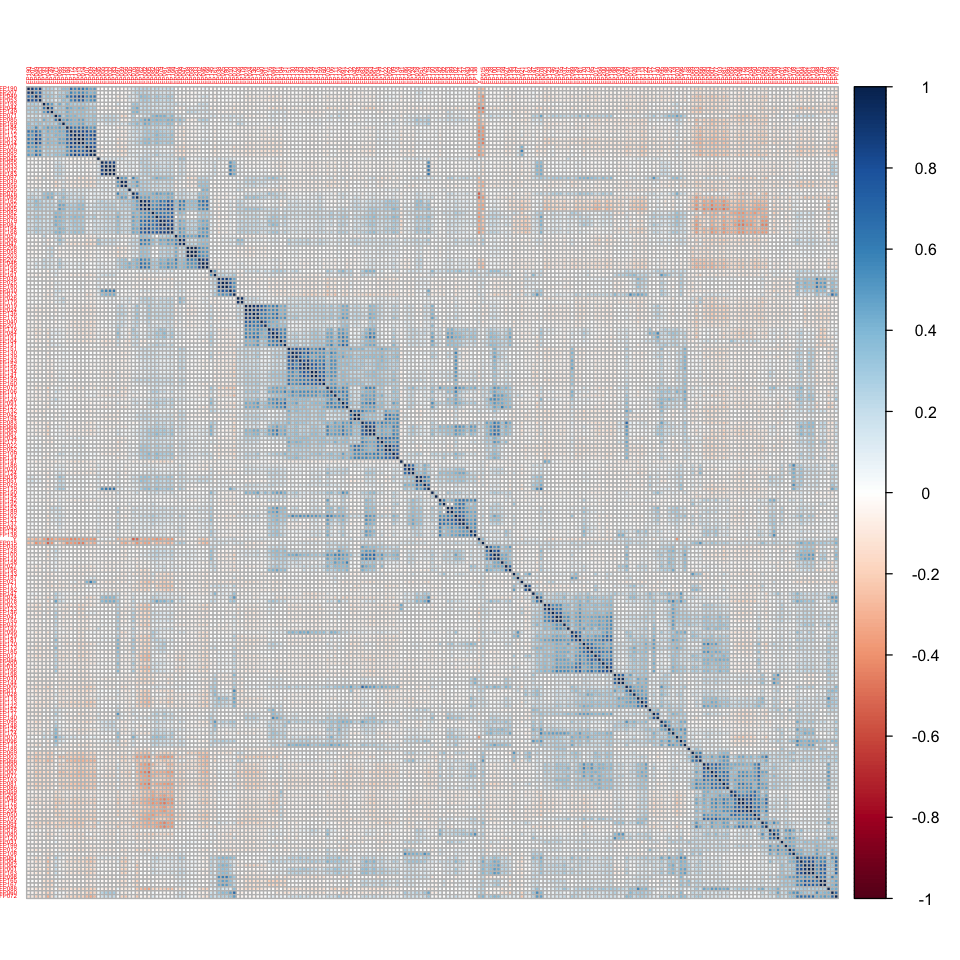

In [234]:
solTemp <- solTrainX[,1:208]
solTemp$Y <- solTrainY
solCorr <- cor(solTemp[,c(209,1:208)])

a <- which.max(solCorr[1,2:209])
cat(a, solCorr[1,a+1])
plotsize(7,3.5)
plot(solCorr[1,2:209], ylab='Correlation with y')
abline(h=0,col=3)
plotsize(8,8)
corrplot::corrplot(solCorr, tl.cex=.3, order="hclust")  # try running with and without hclust
#corrplot::corrplot(solCorr, tl.cex=.3)  

18 0.3090222

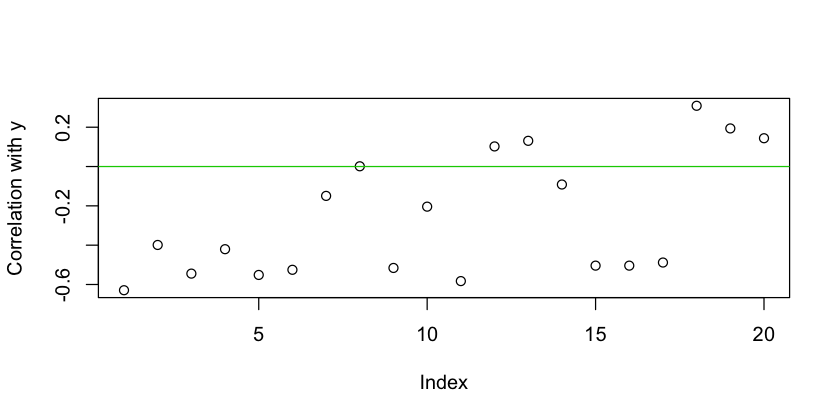

In [235]:
solTemp <- solTrainX[,209:228]
solTemp$Y <- solTrainY
solCorr <- cor(solTemp[,c(21,1:20)])

a <- which.max(solCorr[1,2:21])
cat(a, solCorr[1,a+1])
plotsize(7,3.5)
plot(solCorr[1,2:21], ylab='Correlation with y')
abline(h=0,col=3)

There looks to be a lot of predictive information in these variables.

### solTrainX vs. solTestX

Our task is to predict solTestX data. While they will not span the exact same space at the training data,
it should be close, at least in the ballpark. Let's check the univariate distributions as a basic sanity test.


[1] 0.03164557

[1] 0.6682692

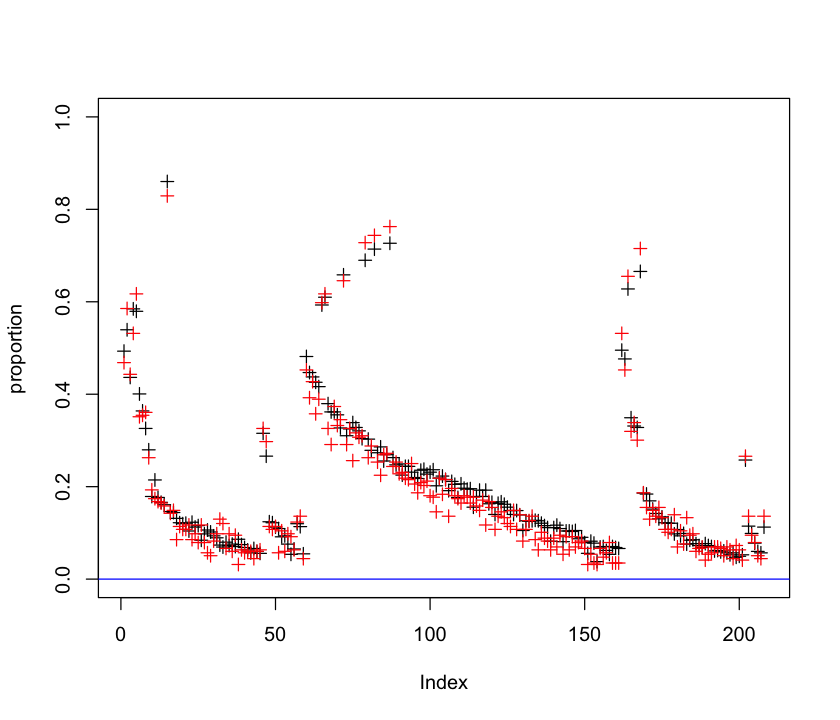

In [236]:
plotsize(7,6)
plot(colMeans(solTrainX[,1:208]),ylab='proportion',ylim=c(0,1),pch=3)
points(temp <- colMeans(solTestX[,1:208]),ylab='proportion',col=2,ylim=c(0,1),pch=3)
min(temp)
abline(h=0,col='blue')
sum(colMeans(solTrainX[,1:208]) > colMeans(solTestX[,1:208]))/208

Hmm... 67% of the binary predictors have more 1's in the training data. A red flag to potential overfitting.

The statistical test:

In [237]:
cat("p-value of similarity is",2*(1-pbinom(0.5 + 0.668*208, 208, 0.5)))

p-value of similarity is 6.666165e-07

In [238]:
rv

FP001 FP002 FP003 FP004 FP005 FP006 FP007 FP008 FP009 FP010 ⋯ NumCarbon
[1,] 0     0     0     0     0     0     0     0     0     0     ⋯  1       
[2,] 1     1     1     1     1     1     1     1     1     1     ⋯ 33       
     NumNitrogen NumOxygen NumSulfer NumChlorine NumHalogen NumRings
[1,] 0            0        0          0           0         0       
[2,] 6           13        4         10          10         7       
     HydrophilicFactor SurfaceArea1 SurfaceArea2
[1,] -0.986              0.00         0.00      
[2,] 13.483            331.94       331.94

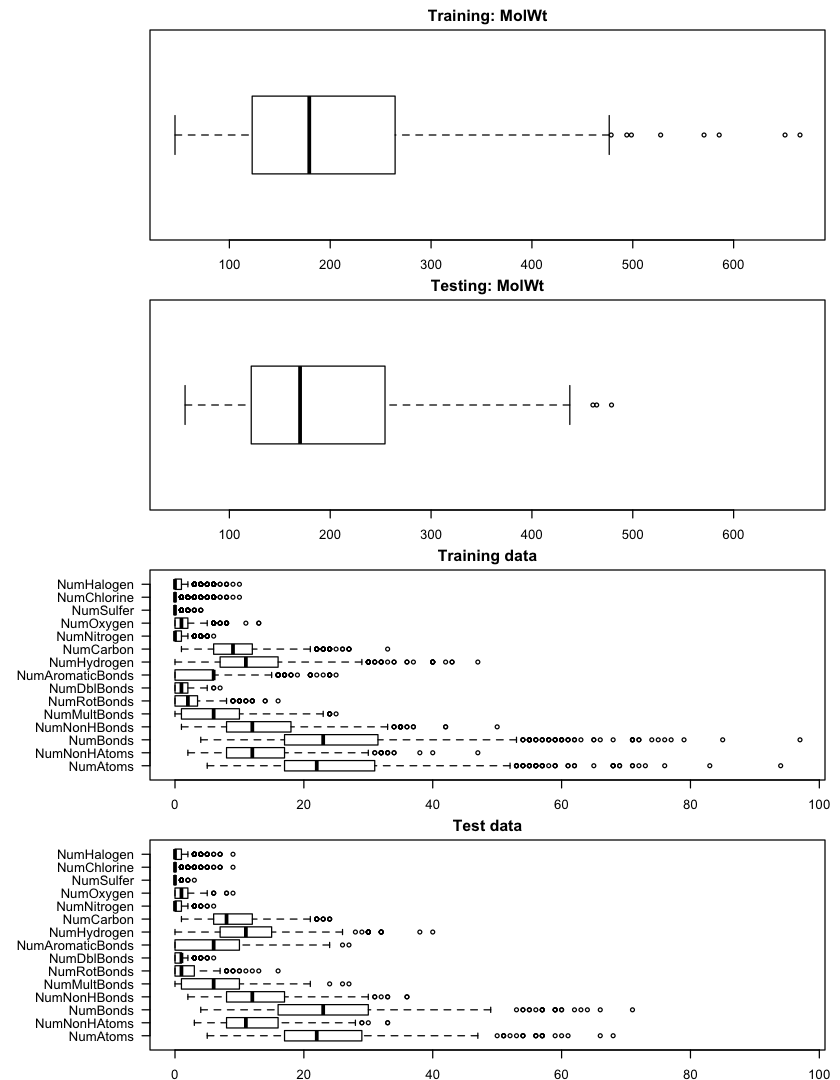

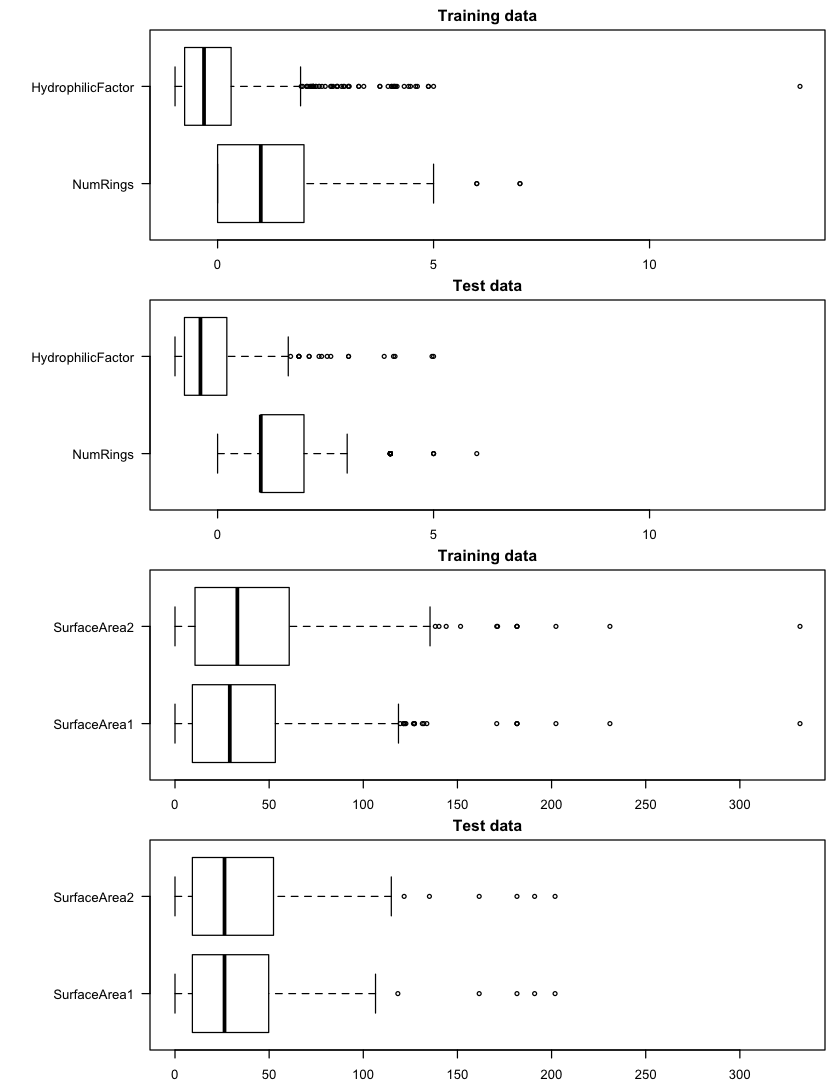

In [239]:
rv = apply(rbind(solTestX, solTrainX), 2, range)
plotsize(7,9)
par(mfrow=c(4,1), las=1, mai=c(.25,1.25,.25,.125))
boxplot(solTrainX[,209], horizontal=T, main="Training: MolWt", ylim=rv[,209])
boxplot(solTestX[,209], horizontal=T, main="Testing: MolWt", ylim=rv[,209])
is.range = 210:224; yrange = c(min(rv[1,is.range]), max(rv[2,is.range]))
boxplot(solTrainX[,is.range], horizontal=T, main="Training data", ylim=yrange)
boxplot(solTestX[,is.range], horizontal=T, main="Test data", ylim=yrange)
is.range = 225:226; yrange = c(min(rv[1,is.range]), max(rv[2,is.range]))
boxplot(solTrainX[,is.range], horizontal=T, main="Training data", ylim=yrange)
boxplot(solTestX[,is.range], horizontal=T, main="Test data", ylim=yrange)
is.range = 227:228; yrange = c(min(rv[1,is.range]), max(rv[2,is.range]))
boxplot(solTrainX[,is.range], horizontal=T, main="Training data", ylim=yrange)
boxplot(solTestX[,is.range], horizontal=T, main="Test data", ylim=yrange)

## Data Exploration

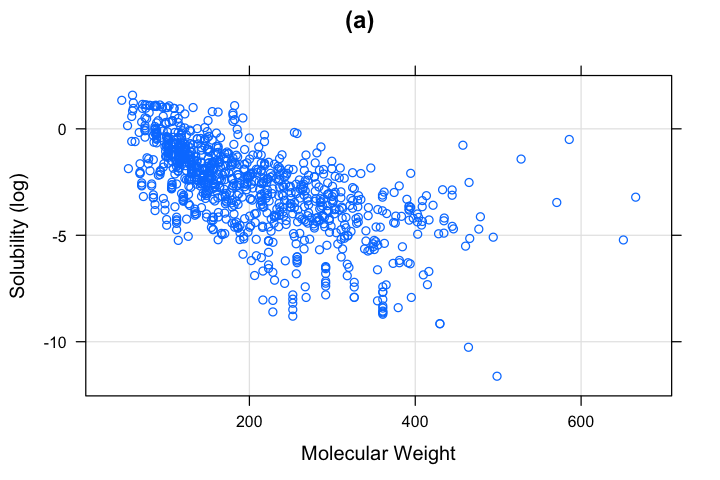

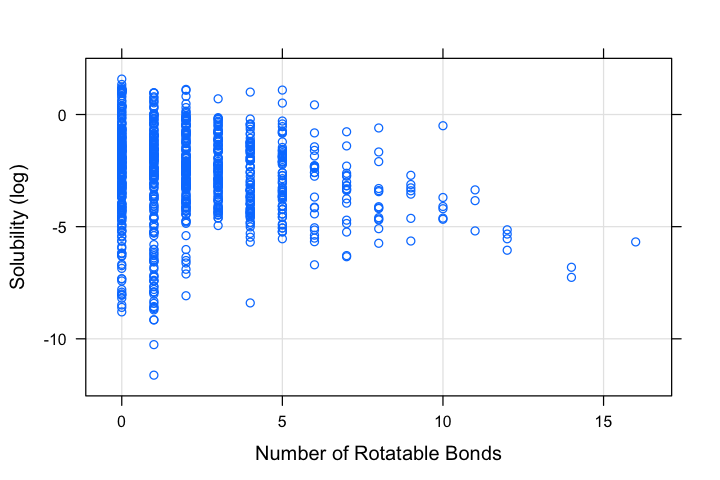

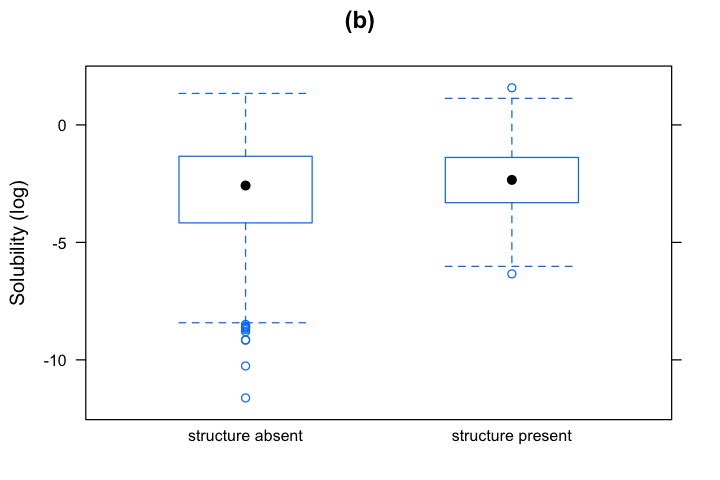

In [240]:
# (C) Kuhn and Johnson (2013)
################################################################################
### Section 6.1 Case Study: Quantitative Structure- Activity
### Relationship Modeling


### Some initial plots of the data
plotsize(6,4)
xyplot(solTrainY ~ solTrainX$MolWeight, type = c("p", "g"),
       ylab = "Solubility (log)",
       main = "(a)",
       xlab = "Molecular Weight")
xyplot(solTrainY ~ solTrainX$NumRotBonds, type = c("p", "g"),
       ylab = "Solubility (log)",
       xlab = "Number of Rotatable Bonds")
bwplot(solTrainY ~ ifelse(solTrainX[,100] == 1, 
                          "structure present", 
                          "structure absent"),
       ylab = "Solubility (log)",
       main = "(b)",
       horizontal = FALSE)

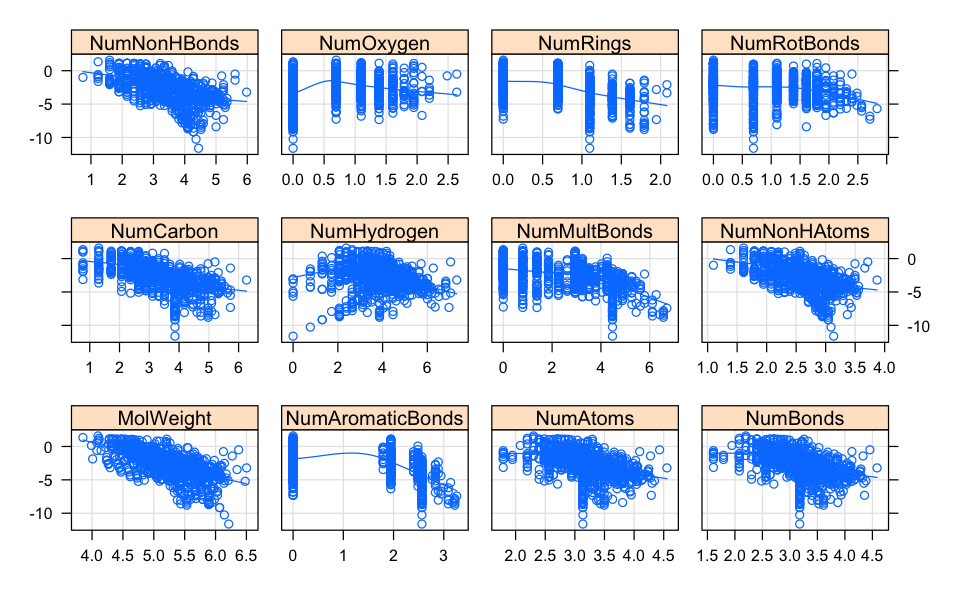

In [241]:
# (C) Kuhn and Johnson (2013)
### Find the columns that are not fingerprints (i.e. the continuous
### predictors). grep will return a list of integers corresponding to
### column names that contain the pattern "FP".

isFingerprints <- grep("FP", names(solTrainXtrans))
notFingerprints <- setdiff(1:ncol(solTrainXtrans),isFingerprints)
plotsize(8,5)
featurePlot(solTrainXtrans[, notFingerprints[c(1:7,9:11,13,17)]],
            solTrainY,
            between = list(x = 1, y = 1),
            type = c("g", "p", "smooth"),
            labels = rep("", 2))

In [242]:
notFingerprints

[1] 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
[20] 228

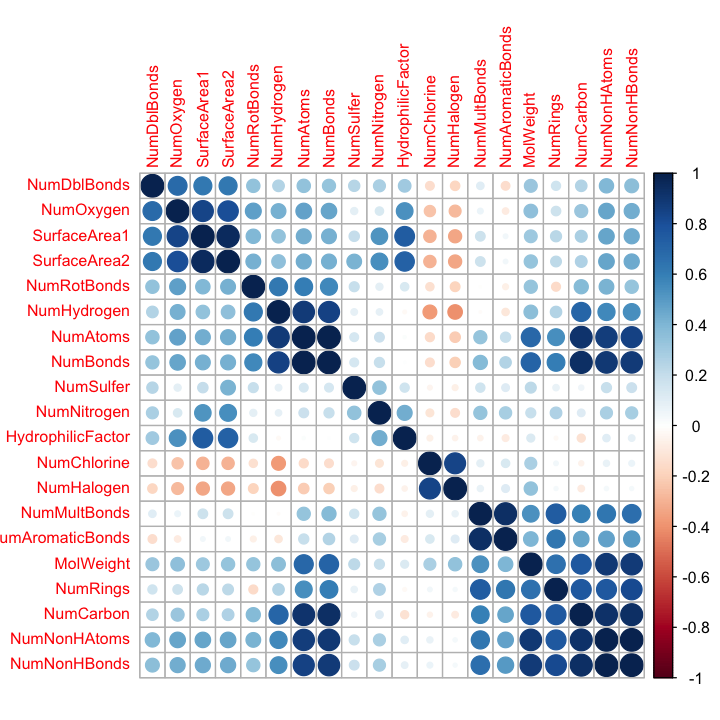

In [243]:
# (C) Kuhn and Johnson (2013)
### We used the full namespace to call this function because the pls
### package (also used in this chapter) has a function with the same
### name.
plotsize(6,6)
corrplot::corrplot(cor(solTrainXtrans[, notFingerprints]), 
                   order = "hclust", 
                   tl.cex = .8)

## Ordinary least squares

Linear Regression employs the least squares solution $\mathbf{b} = (X'X)^{-1} X'y$. Notice that formula
includes $(X'X)^{-1}$,
proportional to the covariance matrix of $\mathbf{X}$. This particular calculation is sensitive to 
multicollinearity, inducing variability of the estimates in $\mathbf{b}$.
We can use the Variance Inflation Factor (VIF) to monitor potential problems with the matrix we
use to calculate the linear regression estimate $\mathbf{b}$.

Note: with limited data relative to the number of predictors $p$ (which includes all data sets today),
influential observations greatly affect $\mathbf{b}$. We can try a robust regression technique to see 
if we get different results (e.g., Huber residuals that use a squared penalty up to a maxium penalty value).


In [311]:
# (C) Kuhn and Johnson, 2013
################################################################################
### Section 6.2 Linear Regression

### Create a control function that will be used across models. We
### create the fold assignments explicitly instead of relying on the
### random number seed being set to identical values.

set.seed(100)
indx <- createFolds(solTrainY, returnTrain = TRUE, k=4)  # for speed purposes, I use 4-fold CV
str(indx)
ctrl <- trainControl(method = "cv", index = indx)
ctrl$number = length(ctrl$index)  # for some reason, this isn't set correctly in the function trainControl
str(ctrl)

List of 4
 $ Fold1: int [1:714] 1 2 3 4 6 7 8 12 14 15 ...
 $ Fold2: int [1:712] 1 2 3 4 5 7 8 9 10 11 ...
 $ Fold3: int [1:713] 1 3 5 6 7 9 10 11 13 14 ...
 $ Fold4: int [1:714] 2 4 5 6 8 9 10 11 12 13 ...
List of 27
 $ method           : chr "cv"
 $ number           : int 4
 $ repeats          : num 1
 $ search           : chr "grid"
 $ p                : num 0.75
 $ initialWindow    : NULL
 $ horizon          : num 1
 $ fixedWindow      : logi TRUE
 $ skip             : num 0
 $ verboseIter      : logi FALSE
 $ returnData       : logi TRUE
 $ returnResamp     : chr "final"
 $ savePredictions  : logi FALSE
 $ classProbs       : logi FALSE
 $ summaryFunction  :function (data, lev = NULL, model = NULL)  
 $ selectionFunction: chr "best"
 $ preProcOptions   :List of 6
  ..$ thresh   : num 0.95
  ..$ ICAcomp  : num 3
  ..$ k        : num 5
  ..$ freqCut  : num 19
  ..$ uniqueCut: num 10
  ..$ cutoff   : num 0.9
 $ sampling         : NULL
 $ index            :List of 4
  ..$ Fold1: int [1

In [300]:
set.seed(100)
indx20 <- createFolds(solTrainY, returnTrain = TRUE, k=20)
ctrl20 <- trainControl(method = "cv", index = indx20)

### Number of folds

We're using 10 folds in CV (ideally, still too long for some models, so we use 4-fold CV). Some methods take longer to train. You could reduce the nubmer of folds to the 3 to 5 range and perhaps not suffer too much degradation of CV tuning parameter estimates.

In [302]:
# (C) Kuhn and Johnson, 2013
### Linear regression model with all of the predictors. This will
### produce some warnings that a 'rank-deficient fit may be
### misleading'. This is related to the predictors being so highly
### correlated that some of the math has broken down.

set.seed(100)
lmTune0 <- train(x = solTrainXtrans, y = solTrainY,
                 method = "lm",
                 trControl = ctrl)
lmTune0                 

Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”

Linear Regression 

951 samples
228 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 714, 712, 713, 714 
Resampling results:

  RMSE       Rsquared 
  0.7632294  0.8649296

Tuning parameter 'intercept' was held constant at a value of TRUE

In [304]:
# the danger of 4-fold CV:
lmTune0$resample

RMSE      Rsquared  Resample
1 0.8132459 0.8408778 Fold1   
2 0.7379632 0.8808092 Fold2   
3 0.7700711 0.8627116 Fold3   
4 0.7316375 0.8753199 Fold4

List of 2
 $ values : num [1:228] 53433564 1867376 194393 76618 51322 ...
 $ vectors: num [1:228, 1:228] -0.00215 -0.00228 -0.00164 -0.00251 -0.00245 ...


Warning message in plot(log10(ev$values)):
“NaNs produced”

[1]  6.015887e-01  5.763840e-01  5.496318e-01  3.292192e-01  3.111445e-01
[6]  2.489326e-01  1.654898e-01  3.390944e-11 -3.558149e-12

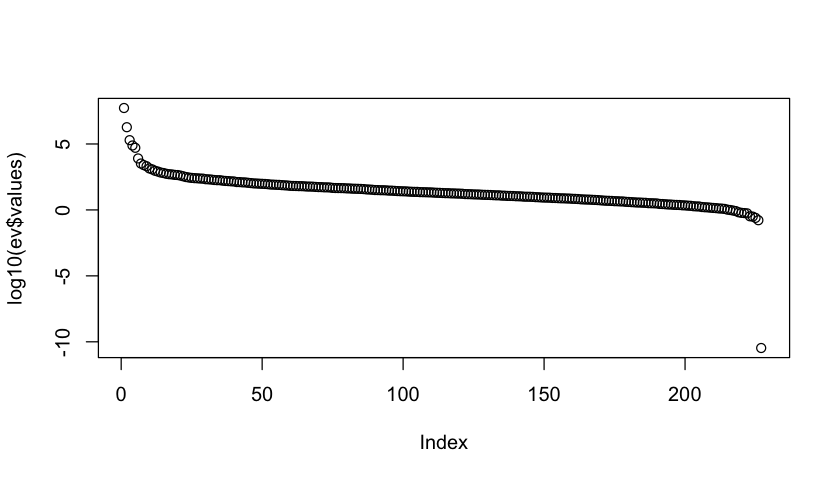

In [247]:
# what does (X'X)^-1 look like?
plotx = as.matrix(solTrainX)
ev = eigen(t(plotx) %*% plotx)
str(ev)
plotsize(7,4)
plot(log10(ev$values))
ev$values[220:228]

There are two problems causing the tiny eigenvalues: (1) NumAtoms/NumBonds,  (2) NonHAtoms/Bonds

In [248]:
cor(solTrainX$NumAtoms, solTrainX$NumBonds)
cor(solTrainX$NumNonHAtoms, solTrainX$NumNonHBonds)

[1] 0.9972283

[1] 0.9944837

In [249]:
col.remove = (colnames(solTrainX) %in% c('NumBonds', 'NumNonHBonds'))
which(col.remove)

[1] 212 213

In [250]:
# (C) Kuhn and Johnson, 2013
### And another using a set of predictors reduced by unsupervised
### filtering. We apply a filter to reduce extreme between-predictor
### correlations. Note the lack of warnings.

tooHigh <- findCorrelation(cor(solTrainXtrans), .95)
tooHigh

[1]  14  33 141 166 167 175 183 208 212 213 217 220 223 224 228  19   1  25  42
[20]  58 134

Now running regression on solTrainXtrans, we don't have multicollinearity warnings:

In [251]:
trainXfiltered <- solTrainXtrans[, -tooHigh]
testXfiltered  <-  solTestXtrans[, -tooHigh]

set.seed(100)
lmTune <- train(x = trainXfiltered, y = solTrainY,
                method = "lm",
                trControl = ctrl)

lmTune

### Save the test set results in a data frame                 
testResults <- data.frame(obs = solTestY,
                          Linear_Regression = predict(lmTune, testXfiltered))

Linear Regression 

951 samples
207 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 714, 712, 713, 714 
Resampling results:

  RMSE      Rsquared 
  0.767721  0.8625358

Tuning parameter 'intercept' was held constant at a value of TRUE

In [252]:
summary(lmTune)

# The resampling Rsquared was 0.87 while the full model 
#     training Rsquared is much higher at 0.94


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.88083 -0.30042  0.00874  0.31417  1.64368 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        9.531279   1.246753   7.645 6.47e-14 ***
FP002              0.402416   0.262152   1.535 0.125198    
FP003             -0.145813   0.134925  -1.081 0.280185    
FP004             -0.195805   0.136393  -1.436 0.151539    
FP005             -0.707129   0.355772  -1.988 0.047224 *  
FP006             -0.308994   0.203822  -1.516 0.129946    
FP007              0.037501   0.118122   0.317 0.750969    
FP008              0.032480   0.161738   0.201 0.840895    
FP009             -0.027495   0.327329  -0.084 0.933080    
FP010              0.553851   0.296433   1.868 0.062102 .  
FP011              0.446775   0.208692   2.141 0.032612 *  
FP012             -0.156092   0.160851  -0.970 0.332157    
FP013             -0.179640   0.366939  -0.490 0.624588

### Stepwise regression

Stepwise regression adds and removes variables based on maximizing likelihood relative
to a coefficient estimation penalty. The default uses AIC.
To speed up the computation, I select only the highest 1/3 of $|t|$ scores in the regression (using the following code block):

In [253]:
trainingData <- solTrainXtrans
trainingData$Solubility <- solTrainY
lmFull <- lm(Solubility ~ ., data=trainingData)
out <- summary(lmFull)
keyvars <- order(out$coefficients[,3])
keyvars <- c(setdiff(keyvars, 1))   # remove intercept (if present)
trainingData <- trainingData[,keyvars[1:80]-1]
trainingData$Solubility <- solTrainY

In [254]:
lmFull <- lm(Solubility ~ ., data=trainingData)
lmReduced <- step(lmFull, trace=0, k = log(nrow(trainingData)))

#### An aside: eyeing signficance or randomness in added-variable plots

In the following stepwise regression, FP154 doesn't look like a real effect (just fitting noise)
while a variable like FP044 does look significant.

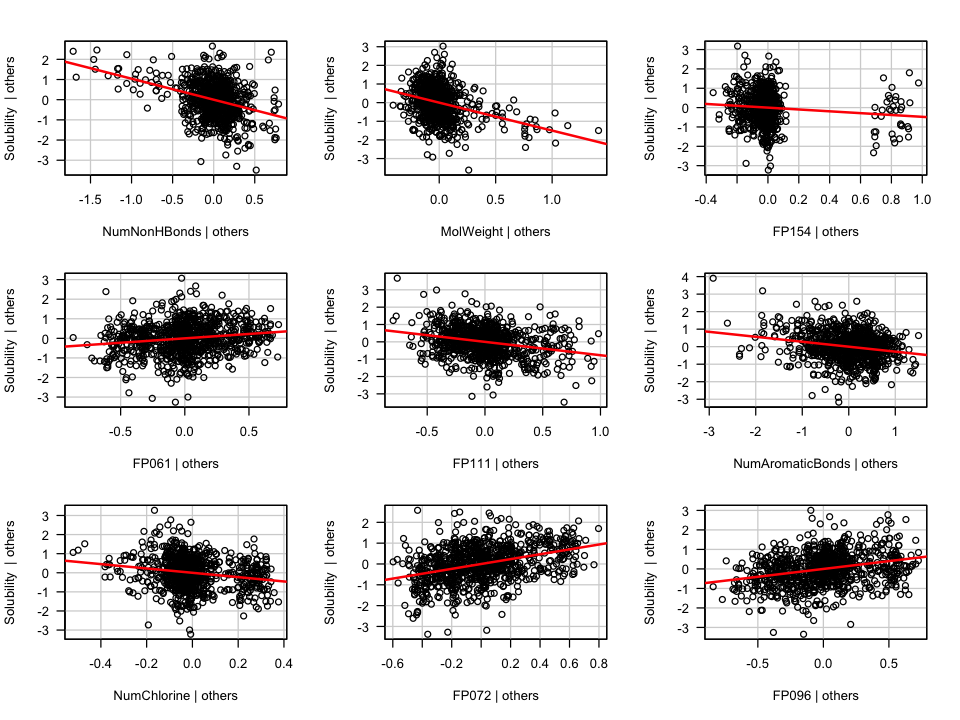

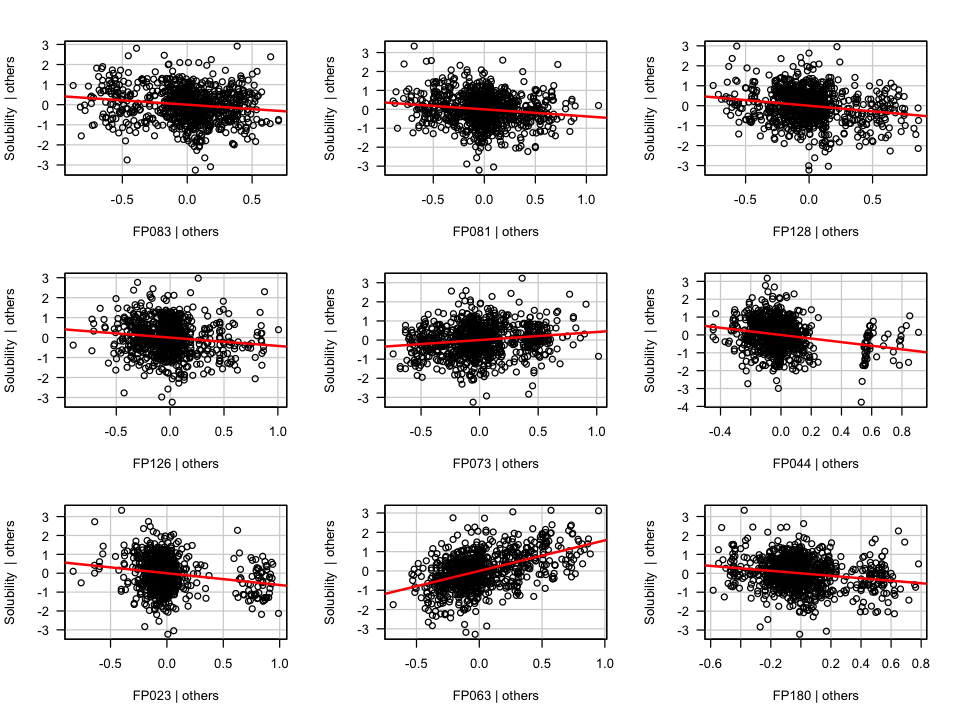

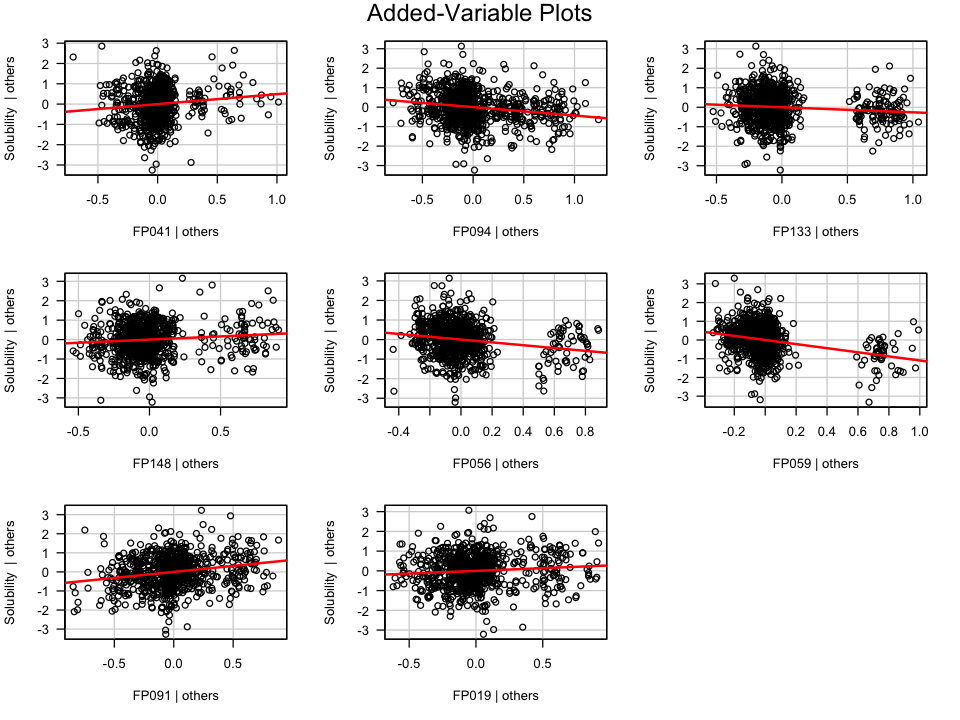

In [255]:
plotsize(8,6)
par(las=1)
avPlots(lmReduced)

In [256]:
Xmat = model.matrix(lmReduced)
dim(Xmat)
head(Xmat)
colnames(Xmat)

[1] 951  27

(Intercept) NumNonHBonds MolWeight FP154 FP061 FP111 NumAromaticBonds
661 1           4.009916     5.343673  0     0     0     2.833213        
662 1           4.871752     5.904108  1     0     0     2.564949        
663 1           3.705506     5.334215  0     1     0     1.945910        
665 1           3.076971     4.921877  0     0     0     0.000000        
668 1           3.705506     5.441335  0     0     1     1.945910        
669 1           3.593860     5.603041  0     0     1     0.000000        
    NumChlorine FP072 FP096 ⋯ FP063 FP180 FP041 FP094 FP133 FP148 FP056 FP059
661 0.0000000   0     0     ⋯ 1     0     0     0     0     0     1     0    
662 0.0000000   1     0     ⋯ 1     0     0     0     0     0     0     0    
663 0.0000000   1     0     ⋯ 0     1     0     0     1     0     0     0    
665 0.0000000   0     0     ⋯ 0     0     1     0     0     0     0     0    
668 0.3750000   0     0     ⋯ 1     0     0     1     0     0     0     0    
669 0.4444444   1     0     ⋯ 1     0     0     0     1     0     0     0    
    FP091 FP019
661 1     1    
662 1     0    
663 0     0    
665 0     0    
668 1     1    
669 0     0

[1] "(Intercept)"      "NumNonHBonds"     "MolWeight"        "FP154"           
 [5] "FP061"            "FP111"            "NumAromaticBonds" "NumChlorine"     
 [9] "FP072"            "FP096"            "FP083"            "FP081"           
[13] "FP128"            "FP126"            "FP073"            "FP044"           
[17] "FP023"            "FP063"            "FP180"            "FP041"           
[21] "FP094"            "FP133"            "FP148"            "FP056"           
[25] "FP059"            "FP091"            "FP019"


	Kruskal-Wallis rank sum test

data:  Q by C
Kruskal-Wallis chi-squared = 6.1013, df = 1, p-value = 0.01351


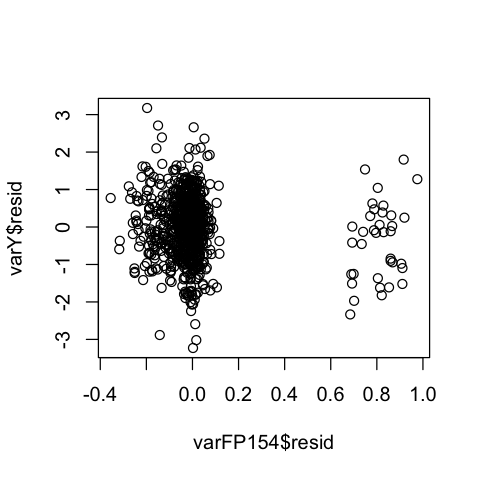

In [257]:
Xmat = as.data.frame(Xmat)
Xmat$Solubility = trainingData$Solubility
varFP154 = lm(FP154 ~ . - Solubility, data=Xmat)
varY = lm(Solubility ~ . - FP154, data=Xmat)
KWdata = data.frame(Q = varY$resid, C = (varFP154$resid > 0.4))
kruskal.test(Q ~ C, data=KWdata)
plotsize(4,4)
plot(varFP154$resid, varY$resid)

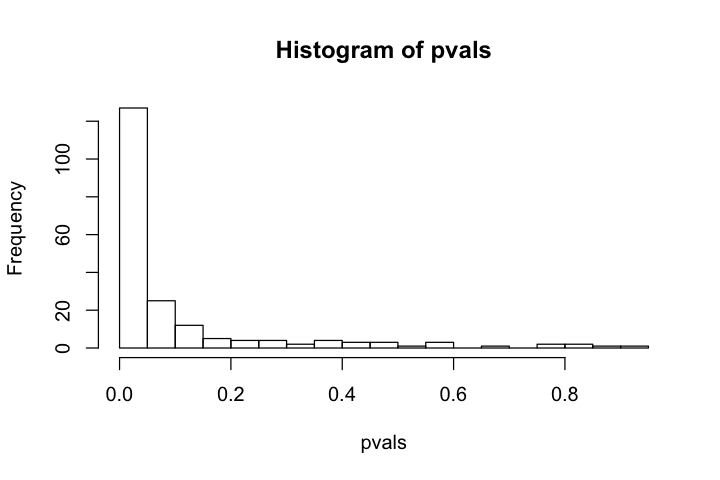

In [264]:
set.seed(0)
pvals = rep(NA,200)
varY = lm(Solubility ~ . - FP154, data=Xmat)
KWdata = data.frame(Q = varY$resid, C = (varFP154$resid > 0.4))
for (i in 1:200){ 
    out = kruskal.test(Q ~ C, data=KWdata[sample(nrow(KWdata), nrow(KWdata), replace=TRUE),])
    pvals[i] = out$p.value
}
plotsize(6,4)
hist(pvals,25)

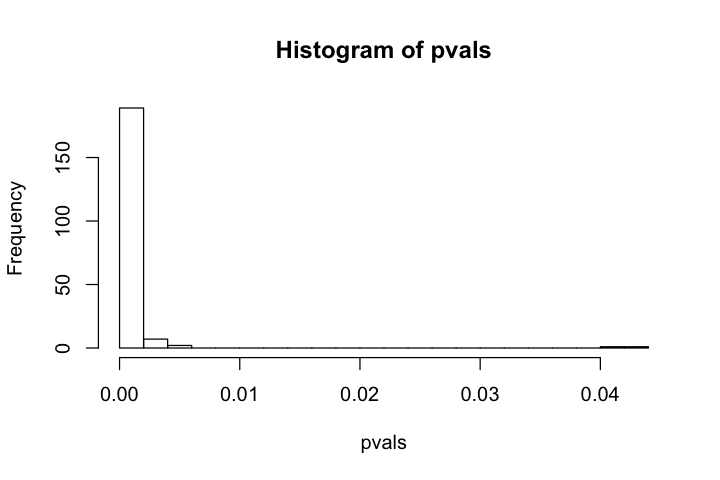

In [261]:
varFP044 = lm(FP023 ~ . - Solubility, data=Xmat)
varY = lm(Solubility ~ . - FP023, data=Xmat)
KWdata = data.frame(Q = varY$resid, C = (varFP044$resid > 0.5))
set.seed(0)
pvals = rep(NA,200)
for (i in 1:200){ 
    out = kruskal.test(Q ~ C, data=KWdata[sample(nrow(KWdata), nrow(KWdata), replace=TRUE),])
    pvals[i] = out$p.value
}
hist(pvals, 25)

In [265]:
summary(lmReduced)


Call:
lm(formula = Solubility ~ NumNonHBonds + MolWeight + FP154 + 
    FP061 + FP111 + NumAromaticBonds + NumChlorine + FP072 + 
    FP096 + FP083 + FP081 + FP128 + FP126 + FP073 + FP044 + FP023 + 
    FP063 + FP180 + FP041 + FP094 + FP133 + FP148 + FP056 + FP059 + 
    FP091 + FP019, data = trainingData)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2284 -0.4835  0.0179  0.5329  3.0826 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       7.83880    0.54188  14.466  < 2e-16 ***
NumNonHBonds     -1.04063    0.09605 -10.835  < 2e-16 ***
MolWeight        -1.49868    0.14842 -10.097  < 2e-16 ***
FP154            -0.47647    0.14910  -3.196 0.001442 ** 
FP061             0.45018    0.08935   5.038 5.65e-07 ***
FP111            -0.77153    0.09459  -8.156 1.12e-15 ***
NumAromaticBonds -0.28286    0.04251  -6.654 4.87e-11 ***
NumChlorine      -1.13708    0.19149  -5.938 4.08e-09 ***
FP072             1.16997    0.09401  12.445  < 2e-16 ***
FP

A nice result from stepwise regression is the above summary agrees with our assessment from the added-variable plots. Note that fingerprints 19, 133, 148, and 154 don't look significant and have relative large p-values (for t-test of coefficient significance). Compare with the above lmFull model summary with all coefficient with p-values > 0.01 removed:

```
Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.88083 -0.30042  0.00874  0.31417  1.64368 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        9.531279   1.246753   7.645 6.47e-14 ***
FP040              0.505803   0.176207   2.871 0.004215 ** 
FP061             -0.491600   0.137319  -3.580 0.000366 ***
FP073             -0.590945   0.209965  -2.814 0.005015 ** 
FP076              0.726063   0.170738   4.252 2.38e-05 ***
FP079              0.625276   0.187041   3.343 0.000870 ***
FP081             -0.293340   0.108986  -2.692 0.007272 ** 
FP082              0.273170   0.097349   2.806 0.005146 ** 
FP085             -0.403105   0.143853  -2.802 0.005208 ** 
FP087              0.692471   0.263050   2.632 0.008653 ** 
FP096             -0.409433   0.146340  -2.798 0.005278 ** 
FP109              0.663429   0.221248   2.999 0.002803 ** 
FP111             -0.443722   0.144305  -3.075 0.002183 ** 
FP119              0.780114   0.270026   2.889 0.003977 ** 
FP127             -0.725249   0.171165  -4.237 2.55e-05 ***
FP130             -1.033193   0.379176  -2.725 0.006585 ** 
FP142              0.572553   0.149489   3.830 0.000139 ***
FP143              0.751869   0.285099   2.637 0.008533 ** 
FP154             -0.825790   0.200460  -4.119 4.22e-05 ***
FP164              0.607709   0.192168   3.162 0.001629 ** 
FP171              0.423581   0.120090   3.527 0.000446 ***
FP176              0.797610   0.253882   3.142 0.001747 ** 
FP202              0.480010   0.180908   2.653 0.008140 ** 
MolWeight         -1.422025   0.231033  -6.155 1.23e-09 ***
NumRotBonds       -0.460000   0.133451  -3.447 0.000599 ***
NumHydrogen        0.497291   0.157906   3.149 0.001702 ** 
NumOxygen          1.493861   0.401794   3.718 0.000216 ***
NumRings          -1.887635   0.441071  -4.280 2.12e-05 ***
SurfaceArea1       0.278697   0.039748   7.012 5.30e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5806 on 743 degrees of freedom
Multiple R-squared:  0.9371,	Adjusted R-squared:  0.9195 
F-statistic: 53.43 on 207 and 743 DF,  p-value: < 2.2e-16
```

#### Another aside: Variable screening

In [268]:
# Need to find the top 1/3 of variables for stepwise regression
# Perform stepwise on smaller datasets and keep track of those in final model
coltimes = rep(0, ncol(solTrainXtrans))
for (k in 1:20){
    #cat("starting CV division",k,"...\n")
    set.seed(k)
    colindex = sample(rep(1:10, length=ncol(solTrainXtrans)))
    for (j in 1:max(colindex)){
        trdat = solTrainXtrans[,colindex == j]
        trdat$Y = solTrainY
        out.full = lm(Y ~ ., data=trdat)
        out.step = step(out.full, trace=0, k=log(nrow(trdat)))
        inmodel = (colnames(solTrainXtrans) %in% colnames(out.step$model))
        coltimes[inmodel] = coltimes[inmodel] + 1
        }
    }
# [less than 1 minute to run]

[1] 125

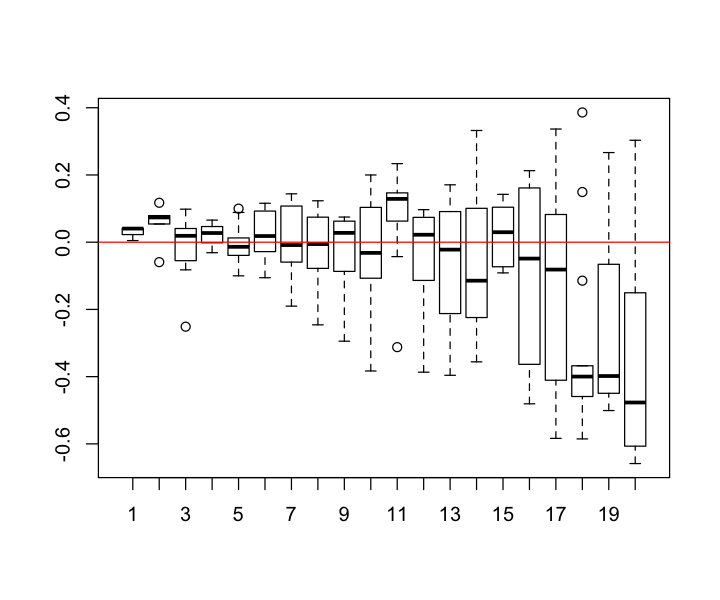

In [271]:
plotsize(6,5)
boxplot(cor(solTrainXtrans, solTrainY) ~ coltimes)
abline(h=0, col='red')
sum(coltimes >= 10)

In [332]:
trainingData <- solTrainXtrans[, coltimes >= 10]
testingData <- solTestXtrans[, coltimes >= 10]
trainingData$Solubility <- solTrainY
lmFull <- lm(Solubility ~ ., data=trainingData)
out <- summary(lmFull)

In [273]:
starttime <- proc.time()[3]
lmReducedVS <- step(lmFull, trace=0, k = log(nrow(trainingData)))
proc.time()[3] - starttime

elapsed 
 55.142

In [274]:
summary(lmReducedVS)


Call:
lm(formula = Solubility ~ FP002 + FP004 + FP005 + FP039 + FP040 + 
    FP053 + FP059 + FP061 + FP065 + FP068 + FP072 + FP074 + FP075 + 
    FP083 + FP085 + FP088 + FP089 + FP096 + FP099 + FP101 + FP111 + 
    FP124 + FP129 + FP135 + FP142 + FP152 + FP168 + FP172 + FP193 + 
    FP202 + FP204 + MolWeight + NumAtoms + NumNonHAtoms + NumBonds + 
    NumNonHBonds + NumRotBonds + NumAromaticBonds + NumHydrogen + 
    NumOxygen + NumRings + SurfaceArea1, data = trainingData)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3331 -0.3543  0.0373  0.3785  2.0109 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        1.14151    1.44437   0.790 0.429550    
FP002              0.57006    0.13575   4.199 2.94e-05 ***
FP004             -0.25297    0.07734  -3.271 0.001113 ** 
FP005              3.08177    0.50466   6.107 1.51e-09 ***
FP039             -0.38219    0.11172  -3.421 0.000652 ***
FP040              0.47755    0.10452   4.569 5.58e-06 **

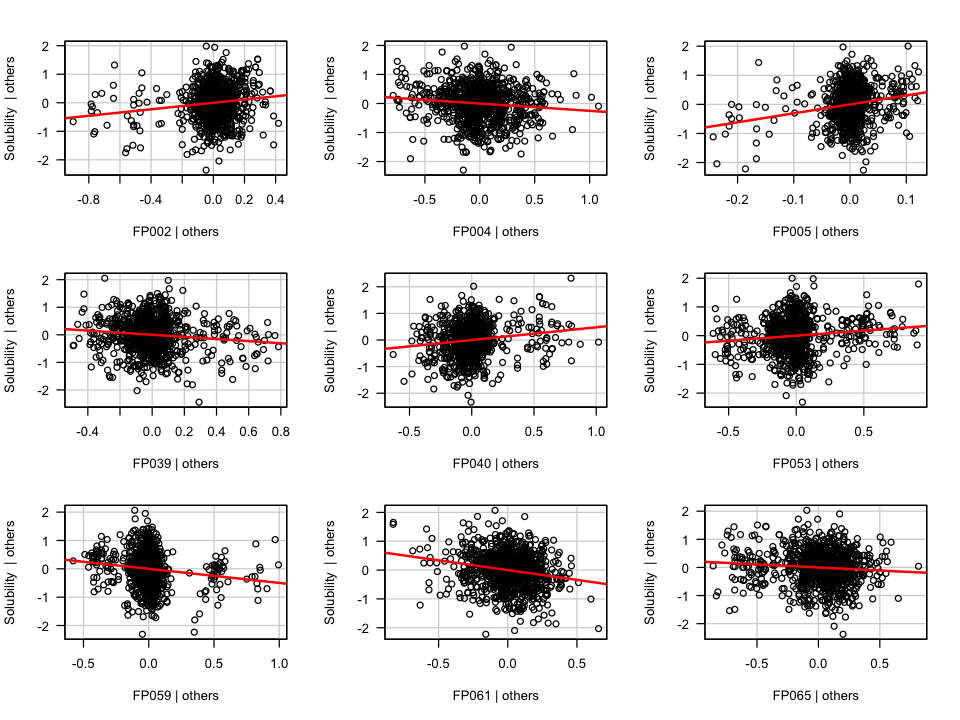

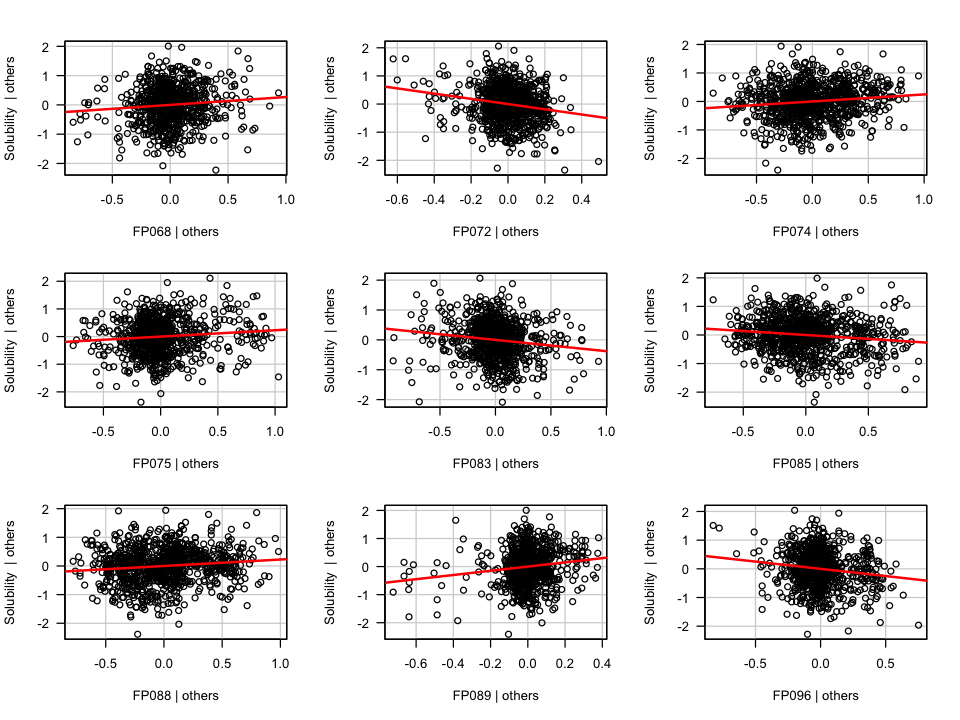

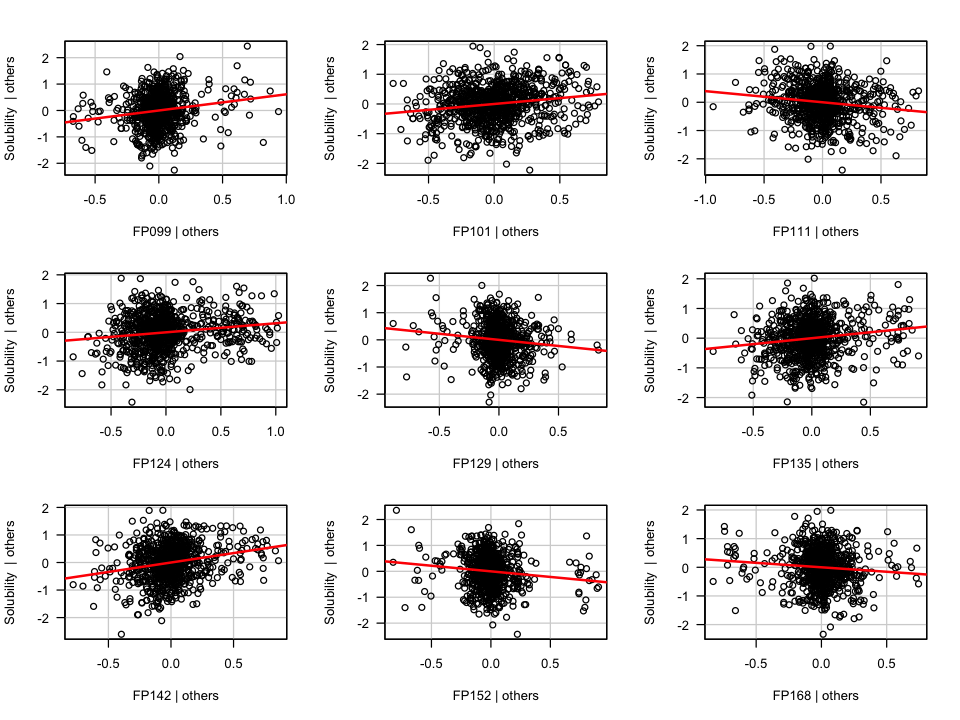

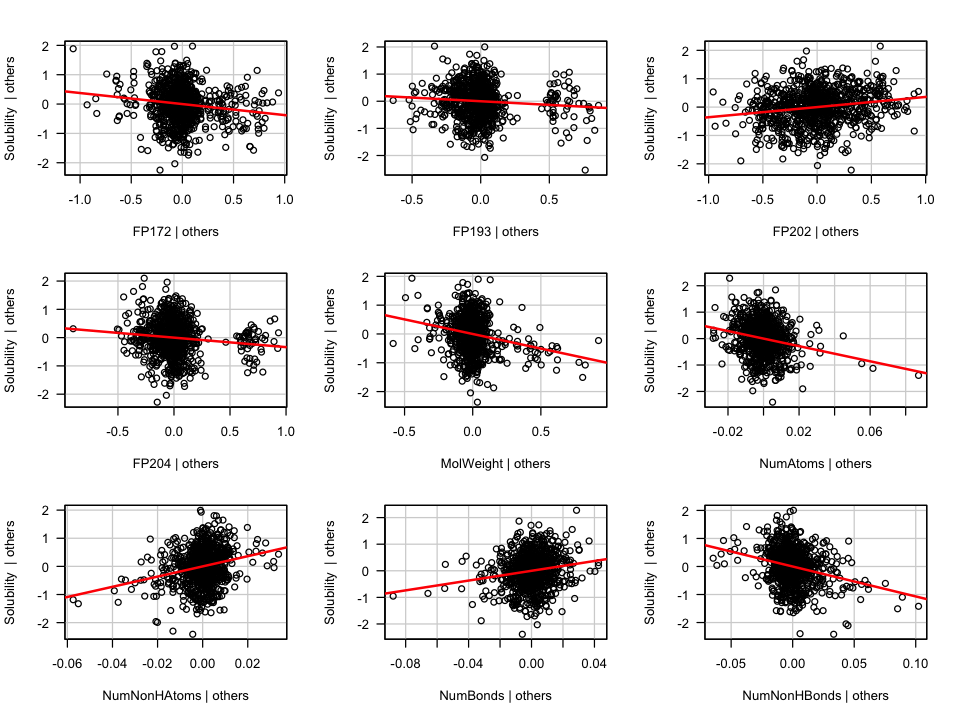

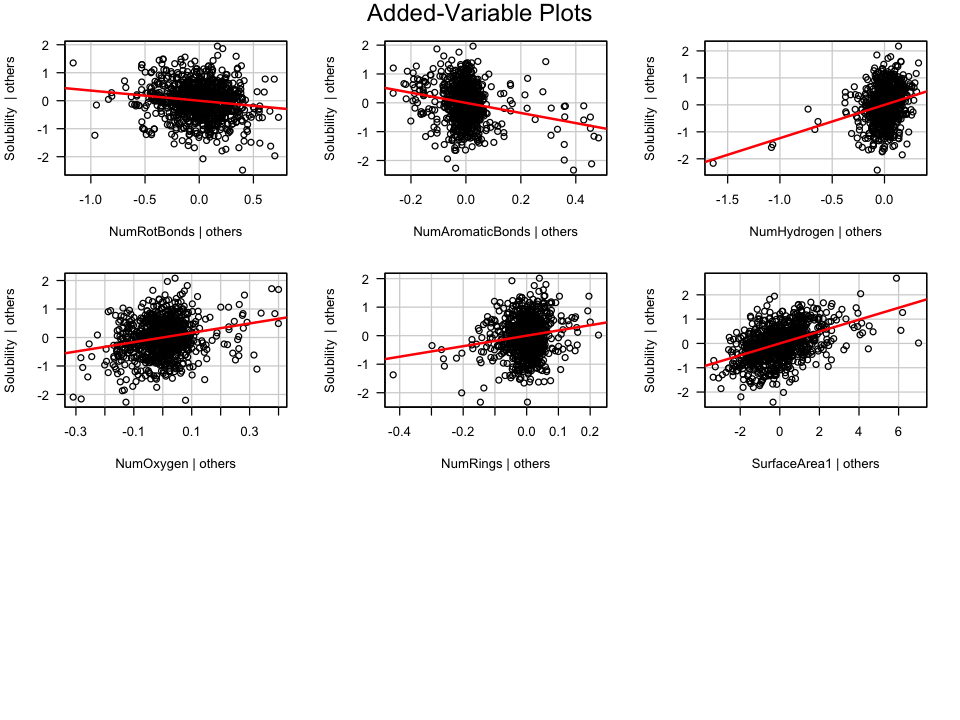

In [275]:
plotsize(8,6)
par(las=1)
avPlots(lmReducedVS)

In [276]:
testResults$step = predict(lmReduced, solTestXtrans)
testResults$stepVS = predict(lmReducedVS, solTestXtrans)
cor(testResults)

obs       Linear_Regression step      stepVS   
obs               1.0000000 0.9313597         0.9071196 0.9337202
Linear_Regression 0.9313597 1.0000000         0.9479945 0.9752667
step              0.9071196 0.9479945         1.0000000 0.9517860
stepVS            0.9337202 0.9752667         0.9517860 1.0000000

In [277]:
a = testResults
for (j in 2:4)
cat(colnames(a)[j], 1 - sum((a[,1] - a[,j])^2)/sum((a[,1]-mean(a[,1]))^2),'\n')

Linear_Regression 0.8663201 
step 0.8214145 
stepVS 0.8713994 


Using a rough variable screening technique yields better results (in a reasonable amount of time). Variable screening techniques become more important as the number of predictors brings some computationally-intense methods to a crawl. Note that the stepVS achieves an $R^2$ of 0.869 while Linear_Regression achieves only 0.866. Compare this to the estimated R2 and R2-adjusted values:

| method | est. $R^2$ | $R^2$-$adj$ | actual $R^2$ |
| --- | ---: | ---: | ---: |
| Linear Regression | 0.937 | 0.920 | 0.866 |
| Step Regression | 0.850 | 0.846 | 0.821 |
| Step with VS | 0.912 | 0.908 | 0.871 |

There is likely something fundamentally different between the training set and the testing set.

### Checking model assumptions

Check for outliers, nonrandomness, other structure, or nonnormality:

- plot of Y vs. Predicted
- plot of Residuals vs. Predicted
- histogram of Residuals (for normality)

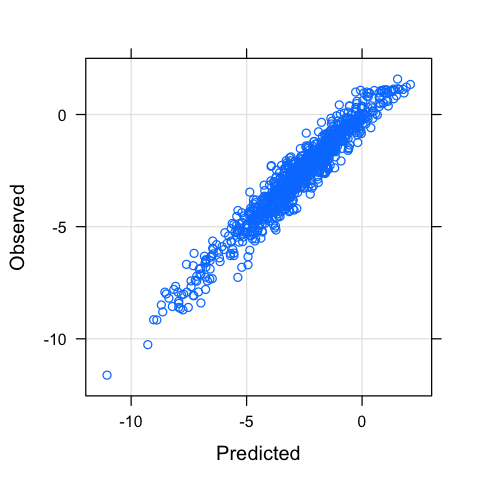

In [278]:
plotsize(4,4)
xyplot(solTrainY ~ predict(lmTune), type=c("p","g"), #plot points (p) and grid (g)
      xlab="Predicted", ylab="Observed")


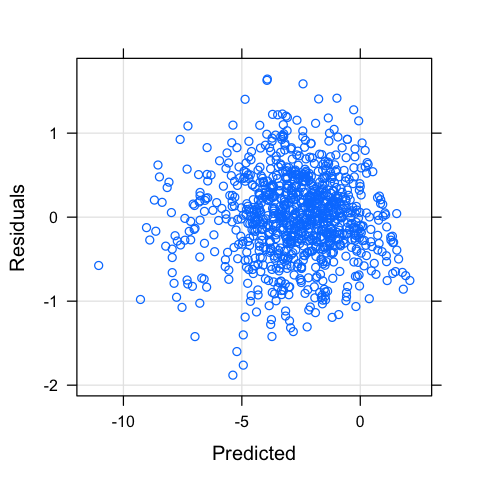

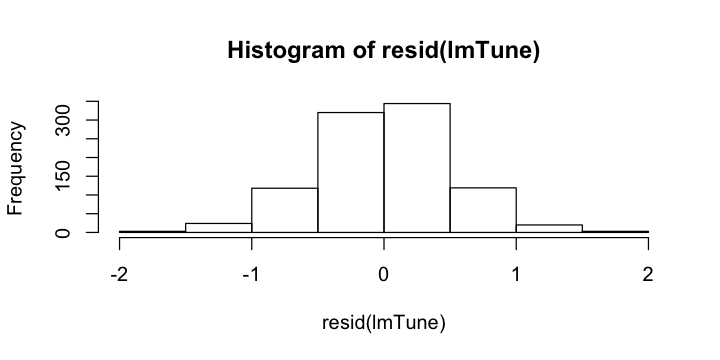

In [279]:
xyplot(resid(lmTune) ~ predict(lmTune), type=c("p","g"), #plot points (p) and grid (g)
      xlab="Predicted", ylab="Residuals")
plotsize(6,3)
hist(resid(lmTune))

In [281]:
# warning: don't rely on shapiro.test... everything is nonnormal with enough data
shapiro.test(resid(lmTune))
# the test suggest rejecting H0: {normal errors}  in favor of H1: {lack of normality}


	Shapiro-Wilk normality test

data:  resid(lmTune)
W = 0.99619, p-value = 0.02004


#### Everything is fine if truly from a normal distribution

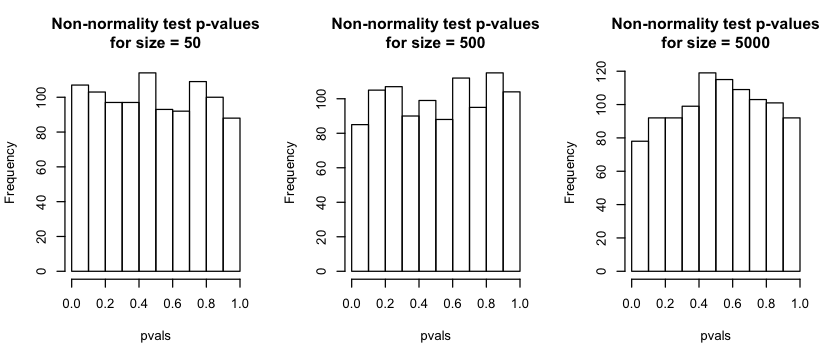

In [198]:
plotsize(7,3)
par(mfrow=c(1,3))
for (j in 1:3){
    sampsize = 5*10^j
    pvals = rep(NA, 1000)
    for (k in 1:length(pvals)){
        set.seed(k)
        a <- rnorm(sampsize)
        pvals[k] = shapiro.test(a)$p.value
    }
    hist(pvals, main=sprintf('Non-normality test p-values\nfor size = %i',sampsize))
}

#### ... but minor deviations that are unconcerning will raise a flag

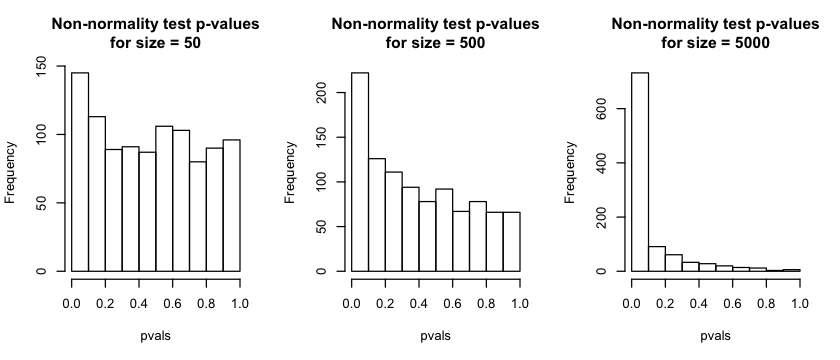

In [282]:
plotsize(7,3)
par(mfrow=c(1,3))
for (j in 1:3){
    sampsize = 5*10^j
    pvals = rep(NA, 1000)
    for (k in 1:length(pvals)){
        set.seed(k)
        a <- rt(sampsize,30)
        pvals[k] = shapiro.test(a)$p.value
    }
    hist(pvals, main=sprintf('Non-normality test p-values\nfor size = %i',sampsize))
}

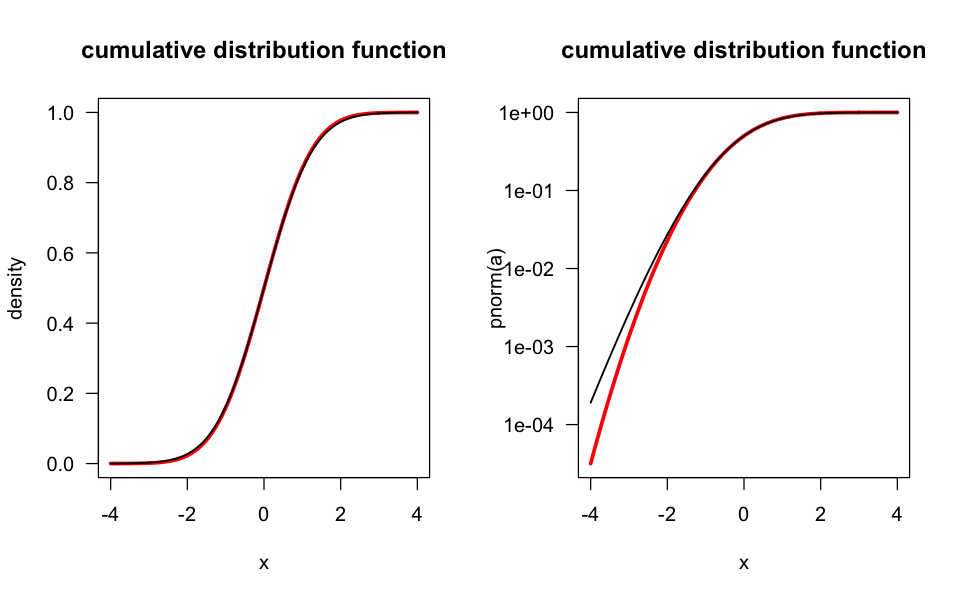

In [211]:
plotsize(8,5)
par(mfrow=c(1,2),las=1)
plot(a <- -400:400/100, pnorm(a), type='l',lwd=3,col='red',xlab='x',ylab='density',
    main='cumulative distribution function')
lines(a, pt(a,30), lwd=1.5)
plot(a <- -400:400/100, pnorm(a), type='l',lwd=3,col='red',log='y',xlab='x',
     main='cumulative distribution function')
lines(a, pt(a,30), lwd=1.5)


seen another way, standard normals rounded to the nearest 0.1 lead to a nonnormal test result for large samples

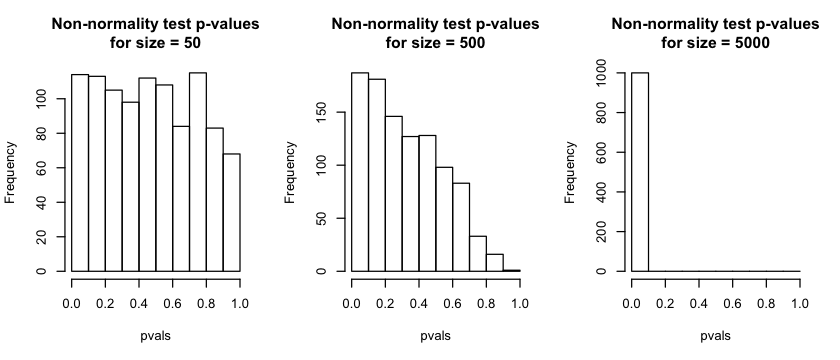

In [220]:
plotsize(7,3)
par(mfrow=c(1,3))
for (j in 1:3){
    sampsize = 5*10^j
    pvals = rep(NA, 1000)
    for (k in 1:length(pvals)){
        set.seed(k)
        a <- round(rnorm(sampsize),1)
        pvals[k] = shapiro.test(a)$p.value
    }
    hist(pvals, main=sprintf('Non-normality test p-values\nfor size = %i',sampsize), breaks=0:10/10)
}

To get a favor of how complicated regression in _caret_ can be:

In [284]:
rlmPCA <- train(solTrainXtrans, solTrainY, method="rlm", # robust linear model
               preProcess = "pca", # using PCA preprocessing, as in Class 1
               trControl = ctrl)
rlmPCA

Robust Linear Model 

951 samples
228 predictors

Pre-processing: principal component signal extraction (228), centered
 (228), scaled (228) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 714, 712, 713, 714 
Resampling results across tuning parameters:

  intercept  psi           RMSE       Rsquared 
  FALSE      psi.huber     2.8244801  0.8527755
  FALSE      psi.hampel    2.8242437  0.8528197
  FALSE      psi.bisquare  2.8244468  0.8527235
   TRUE      psi.huber     0.7905917  0.8526263
   TRUE      psi.hampel    0.7895953  0.8529274
   TRUE      psi.bisquare  0.7951582  0.8507417

RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were intercept = TRUE and psi = psi.hampel.

In [285]:
testResults$RLM <- predict(rlmPCA, solTestXtrans)

## Principal components and Partial least squares regression

#### Principal components regression (PCR)
Singular value decomposition is used to decompose $\mathbf{X}$ ($n \times p$ matrix) into
a orthonormal matrix ($p \times p$) that best explains the
row space of $\mathbf{X}$ (the $\mathbb{R}^p$ space spanned by the rows of $\mathbf{X}$)

Then we see how few of these orthonormal vectors can still yield a good prediction model
for $y$. Note that how the vectors correlate with $y$ are not considered in coming up
with the machinery of the model.
If we decompose $\mathbf{X}'\mathbf{X}$ ($p \times p$ matrix), related to the covariance of $\mathbf{X}$,
we get eigenvectors (the same orthonormal vectors mentioned above) and eigenvalues.
It's the eignevectors of $\mathbf{X}'\mathbf{X}$ that are used as regressors in PCR.

#### Partial least squares regression (PLSR)
Contrasting with the $y$-indifference of PCR is PLSR, where regressors are determined by
their ability to best correlate with $y$. Then we see how few of these $y$-correlated orthonormal
vectors can still yield a good prediction model for $y$.

- Step 1: find $\mathbf{w}$ maximizing $\left| <y, \mathbf{X}\mathbf{w}>\right|$ with $||\mathbf{w}|| = 1$
and $<\ ,\ >$ denoting dot product.
- Step j: find a new $\mathbf{w}$ (orthogonal to all other $\mathbf{w}$ selected so far)
maximizing $\left| <y^{(j-1)}, \mathbf{X}\mathbf{w}>\right|$ with $||\mathbf{w}|| = 1$ where
$y^{(j-1)}$ is the variation of the $y$ not yet explained by the first $j-1$ components.


In [288]:
# (C) Kuhn and Johnson (2013)
################################################################################
### Section 6.3 Partial Least Squares

## Run PLS and PCR on solubility data and compare results
set.seed(100)
plsTune <- train(x = solTrainXtrans, y = solTrainY,
                 method = "pls",
                 tuneGrid = expand.grid(ncomp = 1:20),
                 trControl = ctrl,
                 preProc = c("center", "scale"))
plsTune

Partial Least Squares 

951 samples
228 predictors

Pre-processing: centered (228), scaled (228) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 714, 712, 713, 714 
Resampling results across tuning parameters:

  ncomp  RMSE       Rsquared 
   1     1.2847701  0.6060391
   2     1.0631439  0.7340300
   3     0.9438137  0.7913146
   4     0.8610820  0.8253676
   5     0.8230279  0.8404437
   6     0.7904546  0.8523686
   7     0.7595864  0.8638900
   8     0.7496363  0.8670613
   9     0.7427455  0.8693892
  10     0.7371369  0.8718304
  11     0.7355266  0.8724435
  12     0.7365313  0.8722616
  13     0.7394828  0.8712471
  14     0.7365844  0.8720858
  15     0.7385447  0.8713001
  16     0.7395241  0.8710431
  17     0.7375407  0.8715039
  18     0.7405489  0.8706390
  19     0.7394964  0.8709409
  20     0.7432605  0.8697985

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was ncomp = 11.

In [289]:
testResults$PLS <- predict(plsTune, solTestXtrans)

In [292]:
set.seed(100)
pcrTune <- train(x = solTrainXtrans, y = solTrainY,
                 method = "pcr",
                 tuneGrid = expand.grid(ncomp = 1:40),  
                 trControl = ctrl)
                 # technically, minimum at 150
pcrTune                  

Principal Component Analysis 

951 samples
228 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 714, 712, 713, 714 
Resampling results across tuning parameters:

  ncomp  RMSE       Rsquared  
   1     1.9793445  0.06527653
   2     1.6361649  0.36023430
   3     1.3672407  0.55487462
   4     1.3677256  0.55454864
   5     1.3384546  0.57264083
   6     1.2174304  0.64816262
   7     1.1605416  0.68151157
   8     1.1481894  0.68775119
   9     1.0579073  0.73425216
  10     1.0177000  0.75480429
  11     0.9876299  0.77031998
  12     0.9812137  0.77330600
  13     0.9722017  0.77749723
  14     0.9538373  0.78571424
  15     0.9557040  0.78493485
  16     0.8908691  0.81392789
  17     0.8834280  0.81723062
  18     0.8786584  0.81905652
  19     0.8801428  0.81847917
  20     0.8745989  0.82072111
  21     0.8291275  0.83925721
  22     0.8176284  0.84326043
  23     0.8164309  0.84361040
  24     0.8170198  0.84353418
  25     0.8152417

In [294]:
plsResamples <- plsTune$results
plsResamples$Model <- "PLS"
pcrResamples <- pcrTune$results
pcrResamples$Model <- "PCR"
plsPlotData <- rbind(plsResamples, pcrResamples)

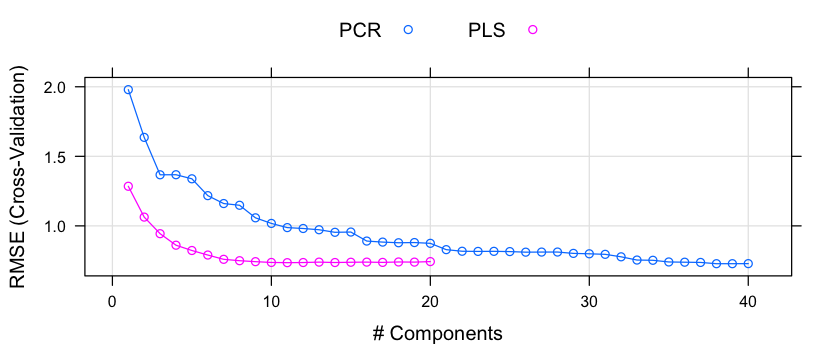

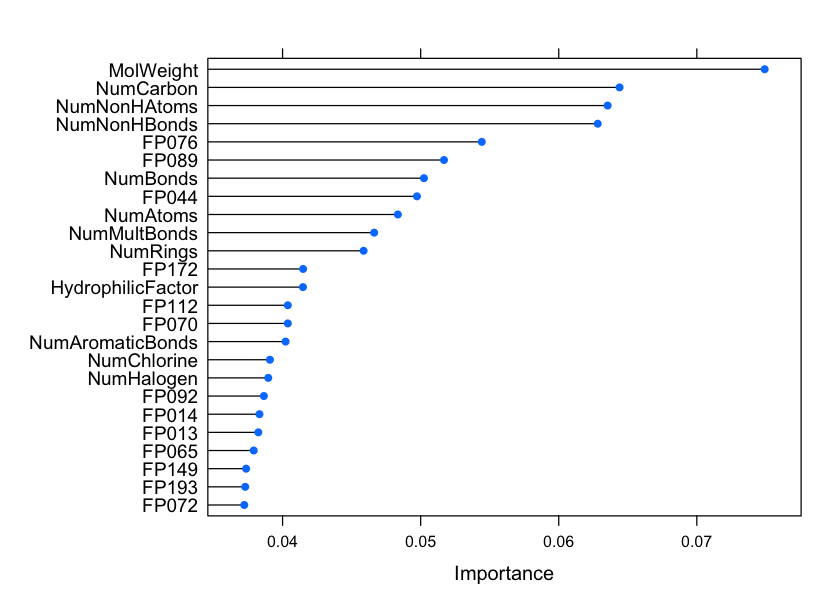

In [295]:
xyplot(RMSE ~ ncomp,
       data = plsPlotData,
       #aspect = 1,
       xlab = "# Components",
       ylab = "RMSE (Cross-Validation)",
       auto.key = list(columns = 2),
       groups = Model,
       type = c("o", "g"))

plsImp <- varImp(plsTune, scale = FALSE)
plotsize(7,5)
plot(plsImp, top = 25, scales = list(y = list(cex = .95)))

In [296]:
testResults$PCR <- predict(pcrTune, solTestXtrans)

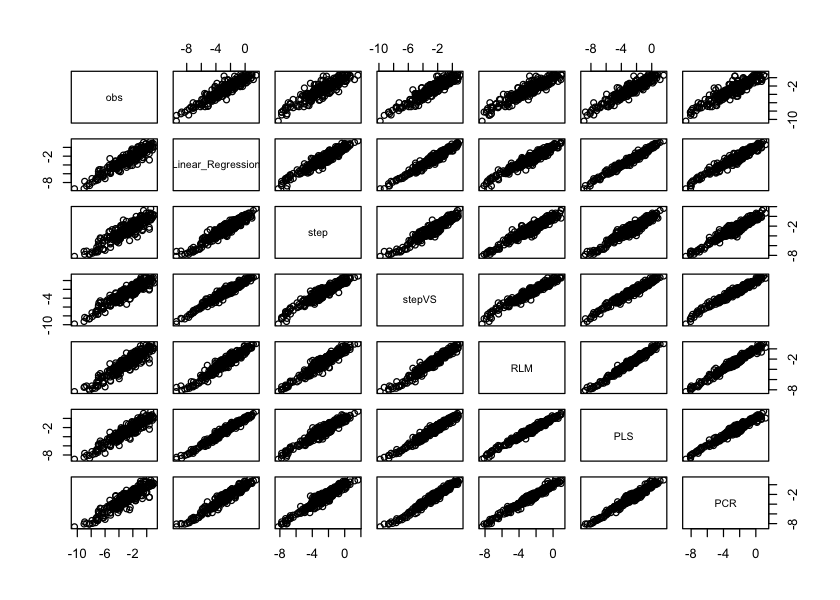

In [297]:
plot(testResults)

In [298]:
cor(testResults)

obs       Linear_Regression step      stepVS    RLM      
obs               1.0000000 0.9313597         0.9071196 0.9337202 0.9258343
Linear_Regression 0.9313597 1.0000000         0.9479945 0.9752667 0.9629711
step              0.9071196 0.9479945         1.0000000 0.9517860 0.9588928
stepVS            0.9337202 0.9752667         0.9517860 1.0000000 0.9706979
RLM               0.9258343 0.9629711         0.9588928 0.9706979 1.0000000
PLS               0.9391558 0.9842814         0.9557775 0.9779301 0.9865761
PCR               0.9222715 0.9663267         0.9589254 0.9808655 0.9838603
                  PLS       PCR      
obs               0.9391558 0.9222715
Linear_Regression 0.9842814 0.9663267
step              0.9557775 0.9589254
stepVS            0.9779301 0.9808655
RLM               0.9865761 0.9838603
PLS               1.0000000 0.9787236
PCR               0.9787236 1.0000000

## Penalized regression models

Ridge regression finds the linear fit coefficients $\mathbf{b}$ that minimize $SSE + \lambda \sum_j b_j^2$.
This results in a shrinking of the OLS estimate towards zero. Note that $\lambda$ is a penalty to be tuned:
if $\lambda = 0$ then there is no penalty, resulting in the OLS estimate. If $\lambda$ is very large, then
the fit will only include the intercept.

LASSO regression minimizes $SSE + \lambda \sum_j \left|b_j\right|$. This results in a sparse model as coefficients
will often be zeroed out to reduce the fit's penalty.

An elastic net is a combination (and is superior) to both of these penalized regression models.
Tune an additional parameter $\alpha \in [0,1]$ that emphasizes LASSO ($\alpha=0$) or Ridge ($\alpha=1$). 

In [ ]:
# (C) Kuhn and Johnson (2013)
################################################################################
### Section 6.4 Penalized Models

## The text used the elasticnet to obtain a ridge regression model.
## There is now a simple ridge regression method.

# ridgeGrid <- expand.grid(lambda = seq(0, .1, length = 15))   
    # this is the original call, resulting in:

```
Ridge Regression 

951 samples
228 predictors

Pre-processing: centered (228), scaled (228) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 856, 857, 855, 856, 856, 855, ... 
Resampling results across tuning parameters:

  lambda       RMSE       Rsquared 
  0.000000000  0.7207131  0.8769711
  0.007142857  0.7047552  0.8818659
  0.014285714  0.6964731  0.8847911
  0.021428571  0.6925923  0.8862699
  0.028571429  0.6908607  0.8870609
  0.035714286  0.6904220  0.8874561
  0.042857143  0.6908548  0.8875998
  0.050000000  0.6919152  0.8875759
  0.057142857  0.6934719  0.8874300
  0.064285714  0.6954114  0.8872009
  0.071428571  0.6976723  0.8869096
  0.078571429  0.7002069  0.8865723
  0.085714286  0.7029801  0.8862009
  0.092857143  0.7059656  0.8858041
  0.100000000  0.7091432  0.8853885

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was lambda = 0.03571429.
```

In [317]:
ridgeGrid <- expand.grid(lambda = seq(.03, .05, length = 5)) 
set.seed(100)
ridgeTune <- train(x = solTrainXtrans, y = solTrainY,
                   method = "ridge",
                   tuneGrid = ridgeGrid,
                   trControl = ctrl,
                   preProc = c("center", "scale"))
ridgeTune


Ridge Regression 

951 samples
228 predictors

Pre-processing: centered (228), scaled (228) 
Resampling: Cross-Validated (4 fold) 
Summary of sample sizes: 714, 712, 713, 714 
Resampling results across tuning parameters:

  lambda  RMSE       Rsquared 
  0.030   0.7146464  0.8804333
  0.035   0.7137952  0.8809102
  0.040   0.7134550  0.8812434
  0.045   0.7135146  0.8814678
  0.050   0.7138969  0.8816080

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was lambda = 0.04.

Questions:

- why is the RMSE higher here with 4-fold CV  (instead of 10-fold CV)?
- why is a larger lambda chosen with 4-fold CV?

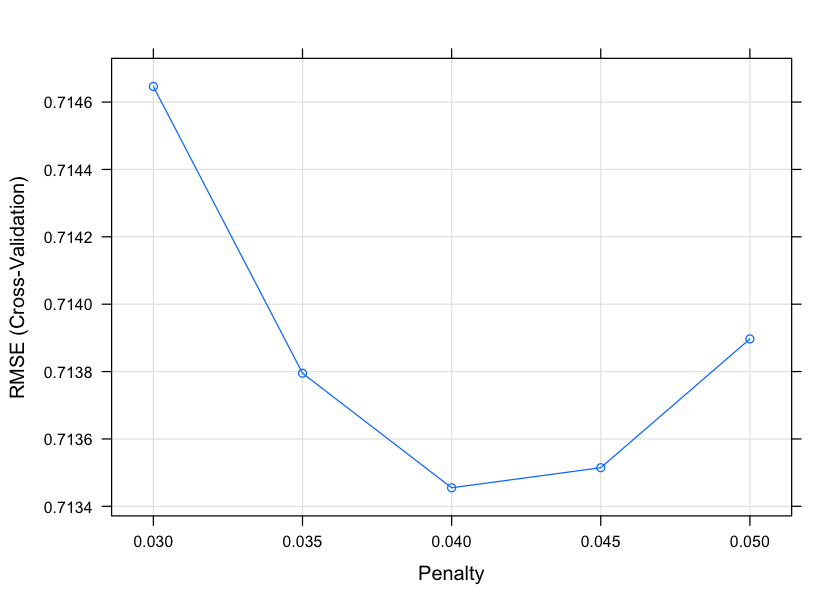

In [318]:
print(update(plot(ridgeTune), xlab = "Penalty"))
testResults$Ridge <- predict(ridgeTune, solTestXtrans)

elapsed 
 22.317

Elasticnet 

951 samples
228 predictors

Pre-processing: centered (228), scaled (228) 
Resampling: Cross-Validated (4 fold) 
Summary of sample sizes: 714, 712, 713, 714 
Resampling results across tuning parameters:

  lambda  fraction  RMSE       Rsquared 
  0.00    0.05      0.8558983  0.8402335
  0.00    0.10      0.6977481  0.8857478
  0.00    0.15      0.6954231  0.8855478
  0.00    0.20      0.7033247  0.8830294
  0.00    0.25      0.7146147  0.8795669
  0.00    0.30      0.7264827  0.8760171
  0.00    0.35      0.7381596  0.8723547
  0.00    0.40      0.7442228  0.8704930
  0.00    0.45      0.7468520  0.8696942
  0.00    0.50      0.7474171  0.8695483
  0.00    0.55      0.7476504  0.8695461
  0.00    0.60      0.7482738  0.8694260
  0.00    0.65      0.7489758  0.8692365
  0.00    0.70      0.7502272  0.8688819
  0.00    0.75      0.7519354  0.8683761
  0.00    0.80      0.7539205  0.8677921
  0.00    0.85      0.7557336  0.8672453
  0.00    0.90      0.7578664  0.8665910
  0.0

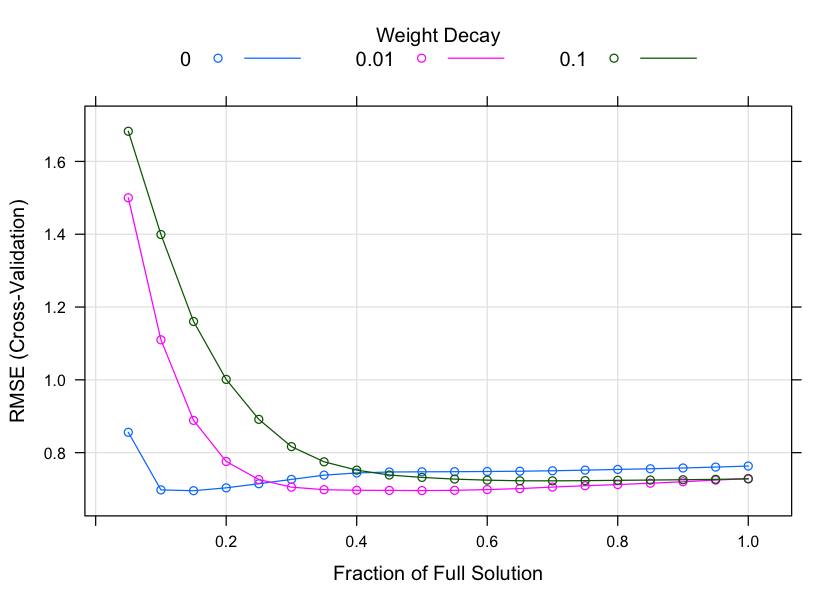

In [320]:
enetGrid <- expand.grid(lambda = c(0, 0.01, .1), 
                        fraction = seq(.05, 1, length = 20))
set.seed(100)
starttime <- proc.time()[3]
enetTune <- train(x = solTrainXtrans, y = solTrainY,
                  method = "enet",
                  tuneGrid = enetGrid,
                  trControl = ctrl,
                  preProc = c("center", "scale"))
proc.time()[3] - starttime
enetTune

plot(enetTune)

testResults$Enet <- predict(enetTune, solTestXtrans)

Elasticnet 

951 samples
228 predictors

Pre-processing: centered (228), scaled (228) 
Resampling: Cross-Validated (4 fold) 
Summary of sample sizes: 714, 712, 713, 714 
Resampling results across tuning parameters:

  lambda  fraction  RMSE       Rsquared 
  0.01    0.40      0.6966915  0.8851580
  0.01    0.45      0.6963102  0.8851669
  0.01    0.50      0.6959188  0.8852447
  0.01    0.55      0.6964799  0.8850942
  0.01    0.60      0.6985363  0.8844835
  0.02    0.40      0.7013337  0.8838869
  0.02    0.45      0.6991341  0.8844340
  0.02    0.50      0.6978714  0.8847609
  0.02    0.55      0.6972920  0.8849490
  0.02    0.60      0.6974494  0.8849530

RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were fraction = 0.5 and lambda = 0.01.

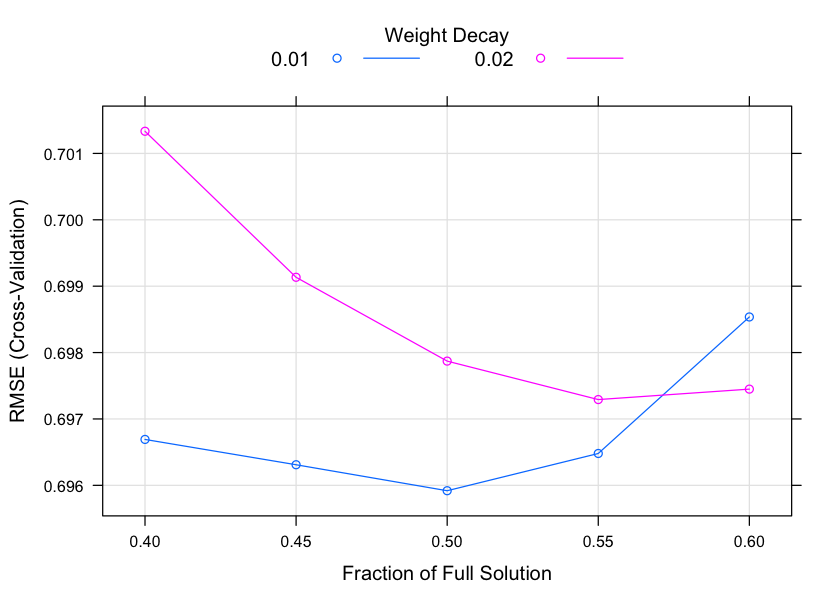

In [327]:
enetGrid2 <- expand.grid(lambda = c(.01, .02), 
                        fraction = seq(.4, .6, length = 5))
enetTune2 <- train(x = solTrainXtrans, y = solTrainY,
                  method = "enet",
                  tuneGrid = enetGrid2,
                  trControl = ctrl,
                  preProc = c("center", "scale"))

enetTune2
plot(enetTune2)

testResults$Enet2 <- predict(enetTune2, solTestXtrans)

In [328]:
cor(testResults)

obs       Linear_Regression step      stepVS    RLM      
obs               1.0000000 0.9313597         0.9071196 0.9337202 0.9258343
Linear_Regression 0.9313597 1.0000000         0.9479945 0.9752667 0.9629711
step              0.9071196 0.9479945         1.0000000 0.9517860 0.9588928
stepVS            0.9337202 0.9752667         0.9517860 1.0000000 0.9706979
RLM               0.9258343 0.9629711         0.9588928 0.9706979 1.0000000
PLS               0.9391558 0.9842814         0.9557775 0.9779301 0.9865761
PCR               0.9222715 0.9663267         0.9589254 0.9808655 0.9838603
Ridge             0.9388013 0.9918569         0.9598637 0.9812712 0.9834781
Enet              0.9413624 0.9882607         0.9635628 0.9879177 0.9834453
Enet2             0.9407979 0.9884263         0.9653210 0.9869279 0.9852944
                  PLS       PCR       Ridge     Enet      Enet2    
obs               0.9391558 0.9222715 0.9388013 0.9413624 0.9407979
Linear_Regression 0.9842814 0.9663267 0.9918569 0.9882607 0.9884263
step              0.9557775 0.9589254 0.9598637 0.9635628 0.9653210
stepVS            0.9779301 0.9808655 0.9812712 0.9879177 0.9869279
RLM               0.9865761 0.9838603 0.9834781 0.9834453 0.9852944
PLS               1.0000000 0.9787236 0.9967179 0.9938003 0.9946541
PCR               0.9787236 1.0000000 0.9813066 0.9861755 0.9862199
Ridge             0.9967179 0.9813066 1.0000000 0.9963090 0.9973560
Enet              0.9938003 0.9861755 0.9963090 1.0000000 0.9996274
Enet2             0.9946541 0.9862199 0.9973560 0.9996274 1.0000000

In [330]:
cat("Training Errors:\n")
fullpred <- predict(enetTune, solTrainXtrans)
cat('Enet: ',1 - sum((fullpred - solTrainY)^2) / sum((solTrainY - mean(solTrainY))^2),": ")
fullpred <- predict(ridgeTune, solTrainXtrans)
cat('Ridge:',1 - sum((fullpred - solTrainY)^2) / sum((solTrainY - mean(solTrainY))^2),": ")
fullpred <- predict(lmReducedVS, solTrainXtrans)
cat('Step: ',1 - sum((fullpred - solTrainY)^2) / sum((solTrainY - mean(solTrainY))^2),":\n")
fullpred <- predict(lmTune, solTrainXtrans)
cat('LM:   ',1 - sum((fullpred - solTrainY)^2) / sum((solTrainY - mean(solTrainY))^2),": ")
fullpred <- predict(rlmPCA, solTrainXtrans)
cat('RLM:  ',1 - sum((fullpred - solTrainY)^2) / sum((solTrainY - mean(solTrainY))^2)," : ")
fullpred <- predict(plsTune, solTrainXtrans)
cat('PLSR: ',1 - sum((fullpred - solTrainY)^2) / sum((solTrainY - mean(solTrainY))^2),": ")
fullpred <- predict(pcrTune, solTrainXtrans)
cat('PCR:  ',1 - sum((fullpred - solTrainY)^2) / sum((solTrainY - mean(solTrainY))^2),"\n")
cat("Testing Errors:\n") 
fullpred <- predict(enetTune, solTestXtrans)
cat('Enet: ',1 - sum((fullpred - solTestY)^2) / sum((solTestY - mean(solTestY))^2)," : ")
fullpred <- predict(ridgeTune, solTestXtrans)
cat('Ridge:',1 - sum((fullpred - solTestY)^2) / sum((solTestY - mean(solTestY))^2),": ")
fullpred <- predict(lmReducedVS, solTestXtrans)
cat('Step: ',1 - sum((fullpred - solTestY)^2) / sum((solTestY - mean(solTestY))^2),":\n")
fullpred <- predict(lmTune, solTestXtrans)
cat('LM:   ',1 - sum((fullpred - solTestY)^2) / sum((solTestY - mean(solTestY))^2),": ")
fullpred <- predict(rlmPCA, solTestXtrans)
cat('RLM:  ',1 - sum((fullpred - solTestY)^2) / sum((solTestY - mean(solTestY))^2),": ")
fullpred <- predict(plsTune, solTestXtrans)
cat('PLSR: ',1 - sum((fullpred - solTestY)^2) / sum((solTestY - mean(solTestY))^2),": ")
fullpred <- predict(pcrTune, solTestXtrans)
cat('PCR:  ',1 - sum((fullpred - solTestY)^2) / sum((solTestY - mean(solTestY))^2),"\n")


Training Errors:
Enet:  0.9227276 : Ridge: 0.9284916 : Step:  0.9124697 :
LM:    0.9370535 : RLM:   0.880426  : PLSR:  0.9171141 : PCR:   0.8852926 
Testing Errors:
Enet:  0.885803  : Ridge: 0.8798271 : Step:  0.8713994 :
LM:    0.8663201 : RLM:   0.8561811 : PLSR:  0.880997 : PCR:   0.8497764 


# Part 6. Nonlinear Regression Models



## Neural Networks

The "traditional" regression methods seem to achieve a training $R^2$ of 0.88-0.89 when predicting solubility
(estimated with 10-fold cross-validation). Using cross-validation gives a more accurate assessment
of how the method performs on future data as those predicted values didn't include their own data
in estimating model coefficients. Contrast this to the training error from the full model:

Neural networks embed a hidden structure that is additive according to some transform of variables.
Each variable and hidden layer add a large number of coefficients to estimate, so tuning
is very important. 

- A single hidden layer is like PLSR in that linear combination coefficients are found
for each node that maximizes predictive ability of $y$, 
except for NNs there is a transform that requires more coefficient estimation.
- Adding a second hidden layer allows a two-stage PLSR where the first layer becomes
features of the predictors (automated _feature engineering_?), aided by the transforms embedded
in the combination process. 


In [344]:
# (C) Kuhn and Johnson, 2013
################################################################################
### Section 7.1 Neural Networks

### Optional: parallel processing can be used via the 'do' packages,
### such as doMC, doMPI etc. We used doMC (not on Windows) to speed
### up the computations.

### WARNING: Be aware of how much memory is needed to parallel
### process. It can very quickly overwhelm the availible hardware. We
### estimate the memory usuage (VSIZE = total memory size) to be 
### 2677M/core.

registerDoMC(4)

# # this took too long to run (not complete after 1 hour)
# nnetGrid <- expand.grid(decay = c(0, 0.01, .1), 
#                         size = c(1, 3, 5, 7, 9, 11, 13), 
#                         bag = FALSE)

# advice when tuning: try an initial grid that is very broad and sparse,
#    like decay = c(0, .5, 10) and size = c(3, 9, 17)
#    and then fine-tune based on results

nnetGrid <- expand.grid(size = c(1, 4, 7, 10), decay = c(0.01, 0.1, 1, 10)) 
#                        bag = FALSE)
nnetGrid

set.seed(100)
indx2 <- createFolds(solTrainY, returnTrain = TRUE, k=2)  # for speed purposes, I use 4-fold CV
str(indx2)
ctrl2 <- trainControl(method = "cv", index = indx2)
ctrl2$number = length(ctrl2$index)  # for some reason, this isn't set correctly in the function trainControl
which(colnames(trainingData) == "Solubility")
dim(trainingData); dim(testingData)

size decay
1   1    0.01
2   4    0.01
3   7    0.01
4  10    0.01
5   1    0.10
6   4    0.10
7   7    0.10
8  10    0.10
9   1    1.00
10  4    1.00
11  7    1.00
12 10    1.00
13  1   10.00
14  4   10.00
15  7   10.00
16 10   10.00

List of 2
 $ Fold1: int [1:475] 1 3 4 6 8 9 11 12 14 17 ...
 $ Fold2: int [1:476] 2 5 7 10 13 15 16 18 23 24 ...


[1] 126

[1] 951 126

[1] 316 125

In [345]:
set.seed(100)
starttime <- proc.time()[3]
nnetTune <- train(x = trainingData[,-126], y = trainingData[,126],
                  method = "nnet",
                  tuneGrid = nnetGrid,
                  trControl = ctrl2,
                  preProc = c("center", "scale"),
                  linout = TRUE,
                  trace = TRUE,
                  #MaxNWts = 13 * (ncol(solTrainXtrans) + 1) + 13 + 1,
                  MaxNWts = 7 * (ncol(testingData) + 1) + 7 + 1,
                  maxit = 250,
                  allowParallel = FALSE)
proc.time()[3] - starttime
nnetTune

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”Warning message in train.default(x = trainingData[, -126], y = trainingData[, 126], :
“missing values found in aggregated results”

# weights:  890
initial  value 9585.425224 
iter  10 value 2232.793634
iter  20 value 1526.400000
iter  30 value 1393.920142
iter  40 value 1128.481718
iter  50 value 826.935972
iter  60 value 755.365096
iter  70 value 715.801095
iter  80 value 637.959174
iter  90 value 564.382399
iter 100 value 551.187837
iter 110 value 534.975691
iter 120 value 520.258302
iter 130 value 503.358268
iter 140 value 497.664079
iter 150 value 490.517130
iter 160 value 485.160240
iter 170 value 481.366710
iter 180 value 478.214630
iter 190 value 475.628634
iter 200 value 473.516252
iter 210 value 471.589907
iter 220 value 469.833317
iter 230 value 468.927843
iter 240 value 467.950582
iter 250 value 467.435811
final  value 467.435811 
stopped after 250 iterations


elapsed 
 15.617

Neural Network 

951 samples
125 predictors

Pre-processing: centered (125), scaled (125) 
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 475, 476 
Resampling results across tuning parameters:

  size  decay  RMSE       Rsquared 
   1     0.01  1.0330161  0.7479345
   1     0.10  0.8069592  0.8490484
   1     1.00  0.8102457  0.8459083
   1    10.00  0.9373774  0.8067731
   4     0.01  1.1842109  0.7042725
   4     0.10  0.9010325  0.8177184
   4     1.00  0.7760414  0.8620772
   4    10.00  0.7412786  0.8718713
   7     0.01  1.1049560  0.7341082
   7     0.10  1.0579855  0.7653938
   7     1.00  0.7129022  0.8832211
   7    10.00  0.7061993  0.8829121
  10     0.01        NaN        NaN
  10     0.10        NaN        NaN
  10     1.00        NaN        NaN
  10    10.00        NaN        NaN

RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were size = 7 and decay = 10.

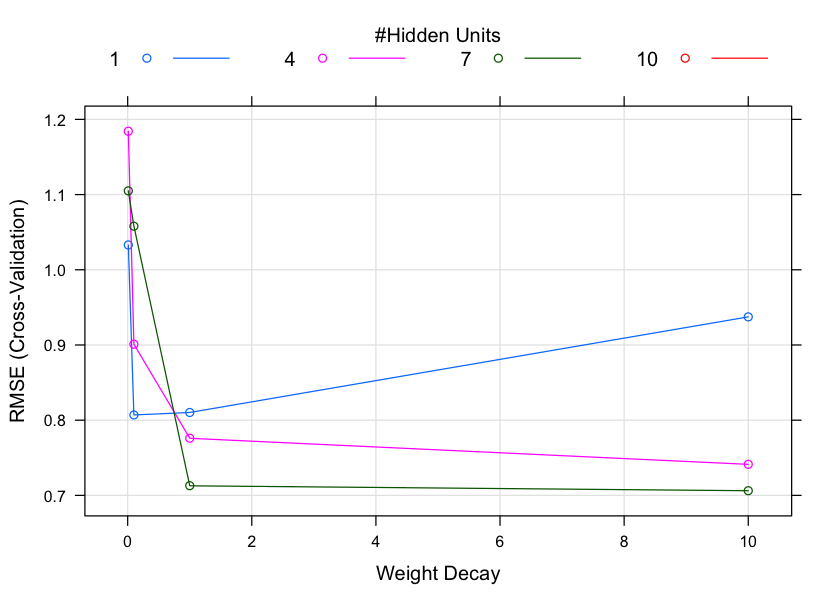

In [346]:
plot(nnetTune)

In [347]:
nnetGrid2 <- rbind(
    expand.grid(size = c(1, 3), decay = c(0.05, 0.2, 0.8)),
    expand.grid(size = c(6, 8), decay = c(0.5, 2, 8)))
    
nnetGrid2


size decay
1  1    0.05 
2  3    0.05 
3  1    0.20 
4  3    0.20 
5  1    0.80 
6  3    0.80 
7  6    0.50 
8  8    0.50 
9  6    2.00 
10 8    2.00 
11 6    8.00 
12 8    8.00

In [348]:
set.seed(100)
starttime <- proc.time()[3]
nnetTune2 <- train(x = trainingData[,-126], y = trainingData[,126],
                  method = "nnet",
                  tuneGrid = nnetGrid2,
                  trControl = ctrl2,
                  preProc = c("center", "scale"),
                  linout = TRUE,
                  trace = TRUE,
                  MaxNWts = 7 * (ncol(testingData) + 1) + 7 + 1,
                  maxit = 250,
                  allowParallel = FALSE)
proc.time()[3] - starttime
nnetTune2

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”Warning message in train.default(x = trainingData[, -126], y = trainingData[, 126], :
“missing values found in aggregated results”

# weights:  763
initial  value 14999.279105 
iter  10 value 3768.894551
iter  20 value 3035.918276
iter  30 value 2171.404942
iter  40 value 1287.525635
iter  50 value 1113.598243
iter  60 value 988.035967
iter  70 value 780.996926
iter  80 value 700.226011
iter  90 value 622.599992
iter 100 value 564.440819
iter 110 value 532.650502
iter 120 value 508.425732
iter 130 value 495.327059
iter 140 value 480.842339
iter 150 value 472.198417
iter 160 value 467.182838
iter 170 value 462.436853
iter 180 value 458.486156
iter 190 value 454.887970
iter 200 value 451.587484
iter 210 value 448.689749
iter 220 value 445.562446
iter 230 value 442.369159
iter 240 value 439.586191
iter 250 value 437.823052
final  value 437.823052 
stopped after 250 iterations


elapsed 
  8.755

Neural Network 

951 samples
125 predictors

Pre-processing: centered (125), scaled (125) 
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 475, 476 
Resampling results across tuning parameters:

  size  decay  RMSE       Rsquared 
  1     0.05   0.8122719  0.8463901
  1     0.20   0.7836828  0.8574688
  1     0.80   0.8057688  0.8479024
  3     0.05   1.0319769  0.7716858
  3     0.20   0.9568722  0.8028368
  3     0.80   0.8034844  0.8503995
  6     0.50   0.7676766  0.8669188
  6     2.00   0.7331277  0.8746203
  6     8.00   0.7040760  0.8830132
  8     0.50         NaN        NaN
  8     2.00         NaN        NaN
  8     8.00         NaN        NaN

RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were size = 6 and decay = 8.

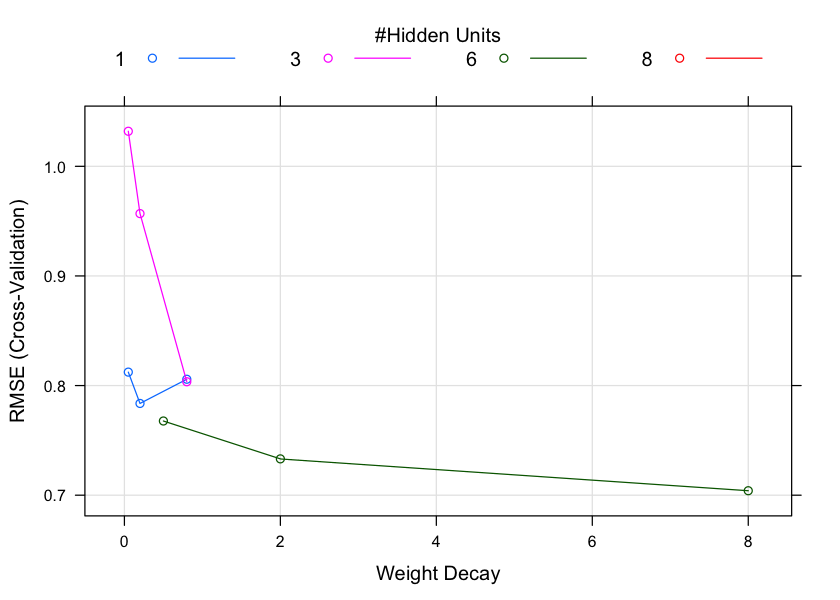

In [349]:
plot(nnetTune2)

In [350]:
nnetGrid3 <- rbind(
    expand.grid(size = c(3, 5), decay = c(0.5, 1.5, 5)),
    expand.grid(size = c(5, 7), decay = c(3, 9, 27)))
    
nnetGrid3


size decay
1  3     0.5 
2  5     0.5 
3  3     1.5 
4  5     1.5 
5  3     5.0 
6  5     5.0 
7  5     3.0 
8  7     3.0 
9  5     9.0 
10 7     9.0 
11 5    27.0 
12 7    27.0

# weights:  890
initial  value 11971.349852 
iter  10 value 3117.259536
iter  20 value 2223.908049
iter  30 value 1890.744877
iter  40 value 1676.390611
iter  50 value 1373.165661
iter  60 value 957.998751
iter  70 value 740.067868
iter  80 value 623.519545
iter  90 value 573.495261
iter 100 value 543.170005
iter 110 value 489.501933
iter 120 value 450.503098
iter 130 value 397.694680
iter 140 value 375.968677
iter 150 value 352.054299
iter 160 value 335.985170
iter 170 value 322.428123
iter 180 value 309.073627
iter 190 value 302.791449
iter 200 value 294.449981
iter 210 value 288.689126
iter 220 value 282.763979
iter 230 value 278.411092
iter 240 value 273.810945
iter 250 value 269.548386
iter 260 value 266.298947
iter 270 value 263.266331
iter 280 value 260.910396
iter 290 value 258.912139
iter 300 value 257.411988
iter 310 value 256.229108
iter 320 value 254.669137
iter 330 value 253.507713
iter 340 value 252.450852
iter 350 value 251.344894
iter 360 value 250.374238
iter 370 value

elapsed 
 24.846

Neural Network 

951 samples
125 predictors

Pre-processing: centered (125), scaled (125) 
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 475, 476 
Resampling results across tuning parameters:

  size  decay  RMSE       Rsquared 
  3      0.5   0.8757235  0.8245615
  3      1.5   0.7818142  0.8570045
  3      5.0   0.7392560  0.8707778
  5      0.5   0.8027845  0.8519641
  5      1.5   0.7152059  0.8800886
  5      3.0   0.7066997  0.8820685
  5      5.0   0.6895219  0.8877755
  5      9.0   0.7160121  0.8793997
  5     27.0   0.8417813  0.8463226
  7      3.0   0.6786068  0.8917519
  7      9.0   0.6994337  0.8847423
  7     27.0   0.8206408  0.8510602

RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were size = 7 and decay = 3.

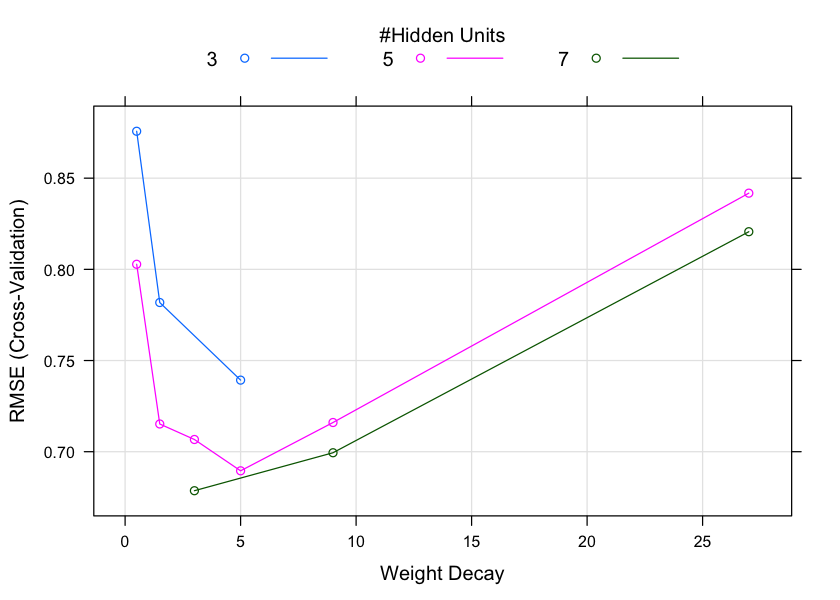

In [354]:
set.seed(100)
starttime <- proc.time()[3]
nnetTune3 <- train(x = trainingData[,-126], y = trainingData[,126],
                  method = "nnet",
                  tuneGrid = nnetGrid3,
                  trControl = ctrl2,
                  preProc = c("center", "scale"),
                  linout = TRUE,
                  trace = TRUE,
                  MaxNWts = 7 * (ncol(testingData) + 1) + 7 + 1,
                  maxit = 1000,
                  allowParallel = FALSE)
proc.time()[3] - starttime
nnetTune3

plot(nnetTune3)

We're getting close, let's concentrate on 5 and 7 nodes and the decay range 1 to 8

In [355]:
nnetGrid4 <- expand.grid(size = c(5, 7), decay = c(1, 2, 4, 8))
    
t(nnetGrid4)

[,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
size  5    7    5    7    5    7    5    7   
decay 1    1    2    2    4    4    8    8

# weights:  890
initial  value 13687.184090 
iter  10 value 4340.000822
iter  20 value 3462.722302
iter  30 value 2889.162930
iter  40 value 2312.655226
iter  50 value 1517.479913
iter  60 value 909.764856
iter  70 value 689.635802
iter  80 value 601.695253
iter  90 value 555.565791
iter 100 value 497.625328
iter 110 value 446.854046
iter 120 value 423.436391
iter 130 value 390.163740
iter 140 value 369.536799
iter 150 value 353.680325
iter 160 value 344.383264
iter 170 value 334.479794
iter 180 value 326.999471
iter 190 value 320.011663
iter 200 value 313.901725
iter 210 value 307.921205
iter 220 value 302.427256
iter 230 value 298.673667
iter 240 value 295.380709
iter 250 value 292.787357
iter 260 value 290.842884
iter 270 value 288.353089
iter 280 value 286.664995
iter 290 value 284.662128
iter 300 value 282.937521
iter 310 value 281.036134
iter 320 value 279.540674
iter 330 value 278.219216
iter 340 value 277.301060
iter 350 value 276.593597
iter 360 value 275.912554
iter 370 value

elapsed 
 23.188

Neural Network 

951 samples
125 predictors

Pre-processing: centered (125), scaled (125) 
Resampling: Cross-Validated (2 fold) 
Summary of sample sizes: 475, 476 
Resampling results across tuning parameters:

  size  decay  RMSE       Rsquared 
  5     1      0.7864647  0.8566869
  5     2      0.7329654  0.8749357
  5     4      0.6960195  0.8861047
  5     8      0.7047492  0.8831901
  7     1      0.7509099  0.8701415
  7     2      0.7057734  0.8834655
  7     4      0.6940575  0.8869245
  7     8      0.6946224  0.8863640

RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were size = 7 and decay = 4.

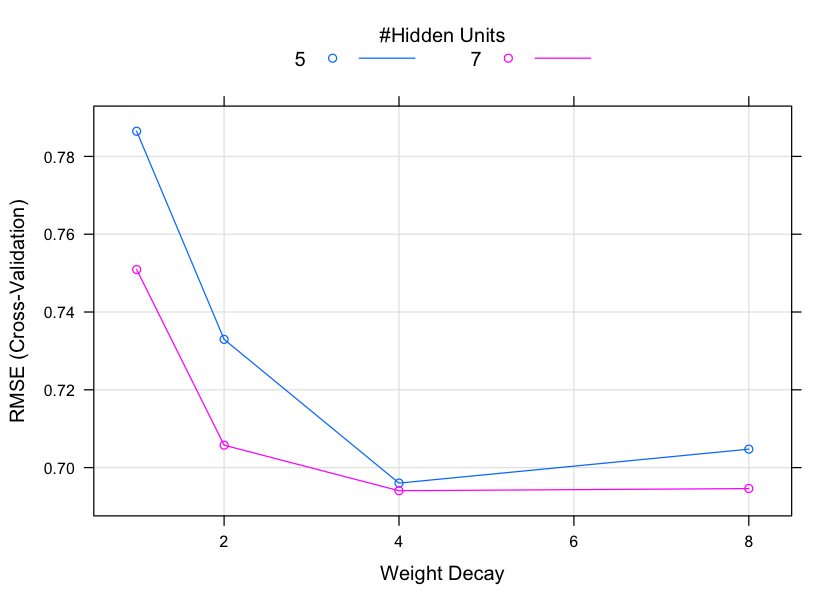

In [356]:
set.seed(100)
starttime <- proc.time()[3]
nnetTune4 <- train(x = trainingData[,-126], y = trainingData[,126],
                  method = "nnet",
                  tuneGrid = nnetGrid4,
                  trControl = ctrl2,
                  preProc = c("center", "scale"),
                  linout = TRUE,
                  trace = TRUE,
                  MaxNWts = 11 * (ncol(testingData) + 1) + 11 + 1,
                  maxit = 1500,
                  allowParallel = FALSE)
proc.time()[3] - starttime
nnetTune4

plot(nnetTune4)

In [357]:
nnetGrid5 <- expand.grid(size = 7, decay = c(5, 8))
    
t(nnetGrid5)

[,1] [,2]
size  7    7   
decay 5    7

# weights:  890
initial  value 23064.197676 
iter  10 value 5768.817089
iter  20 value 4644.092554
iter  30 value 4004.849116
iter  40 value 2227.248502
iter  50 value 1060.475579
iter  60 value 882.858899
iter  70 value 790.013336
iter  80 value 660.153395
iter  90 value 616.424436
iter 100 value 579.504926
iter 110 value 536.389689
iter 120 value 517.130541
iter 130 value 475.310541
iter 140 value 465.677924
iter 150 value 453.998520
iter 160 value 442.346408
iter 170 value 431.856854
iter 180 value 421.887182
iter 190 value 412.367482
iter 200 value 404.905200
iter 210 value 399.017058
iter 220 value 395.948928
iter 230 value 393.963787
iter 240 value 392.097611
iter 250 value 390.604581
iter 260 value 389.482032
iter 270 value 388.643233
iter 280 value 387.356351
iter 290 value 386.254214
iter 300 value 385.310875
iter 310 value 384.661167
iter 320 value 384.111859
iter 330 value 383.742560
iter 340 value 383.455138
iter 350 value 383.262340
iter 360 value 383.081664
iter 370 value

elapsed 
 14.729

Neural Network 

951 samples
125 predictors

Pre-processing: centered (125), scaled (125) 
Resampling: Cross-Validated (4 fold) 
Summary of sample sizes: 714, 712, 713, 714 
Resampling results across tuning parameters:

  decay  RMSE       Rsquared 
  5      0.6761401  0.8915487
  7      0.6717117  0.8935463

Tuning parameter 'size' was held constant at a value of 7
RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were size = 7 and decay = 7.

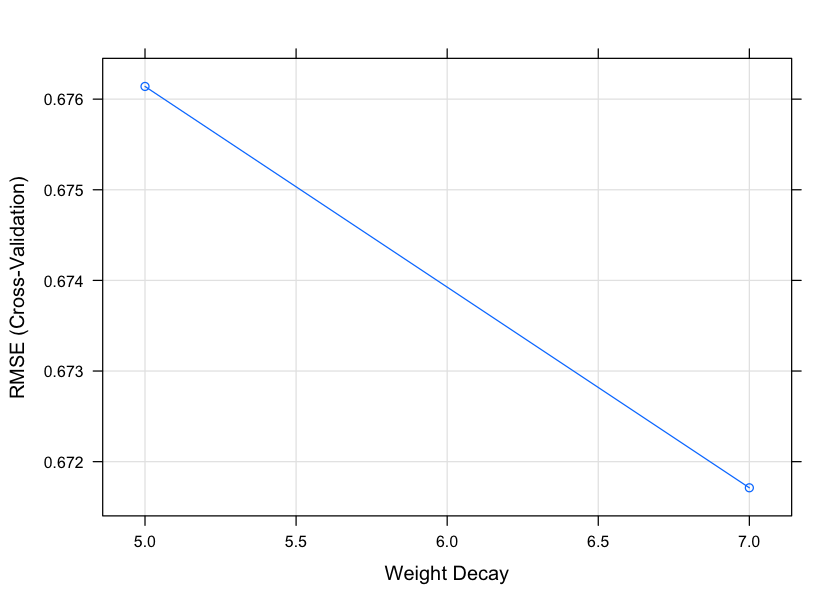

In [358]:
set.seed(100)
starttime <- proc.time()[3]
nnetTune5 <- train(x = trainingData[,-126], y = trainingData[,126],
                  method = "nnet",
                  tuneGrid = nnetGrid5,
                  trControl = ctrl,  # back to 4-fold CV
                  preProc = c("center", "scale"),
                  linout = TRUE,
                  trace = TRUE,
                  MaxNWts = 13 * (ncol(testingData) + 1) + 13 + 1,
                  maxit = 2000,
                  allowParallel = FALSE)
proc.time()[3] - starttime
nnetTune5

plot(nnetTune5)

In [361]:
testResults$NNet = predict(nnetTune5, testingData)
cor(testResults[,c(1,8:11)])

obs       Ridge     Enet      Enet2     NNet     
obs   1.0000000 0.9388013 0.9413624 0.9407979 0.9407308
Ridge 0.9388013 1.0000000 0.9963090 0.9973560 0.9866612
Enet  0.9413624 0.9963090 1.0000000 0.9996274 0.9875520
Enet2 0.9407979 0.9973560 0.9996274 1.0000000 0.9875379
NNet  0.9407308 0.9866612 0.9875520 0.9875379 1.0000000

To use another implementation `avNNet`, the correlated predictors should be removed.

In [362]:
# (C) Kuhn and Johnson, 2013
tooHigh <- findCorrelation(cor(solTrainXtrans), cutoff=.75)
trainXnnet <- solTrainXtrans[, -tooHigh]
testXnnet <- solTestXtrans[, -tooHigh]

In [363]:
startTime <- proc.time()[3]
# nnetGrid <- expand.grid(decay = c(0, 0.01, .1), 
#                         size = c(1, 3, 5, 7, 9, 11, 13), 
#                         bag = TRUE)
broadGrid <- expand.grid(decay = c(1, 10), 
                        size = 7, 
                        bag = TRUE)
broadGrid

# set.seed(100)
# when I mistakenly ran on solTrainXtrans, only [1.5, 5] completed without NA
#     so I assume using trainXnnet for avNNet is required
avNNetTune <- train(trainXnnet, solTrainY, method="avNNet",
                    tuneGrid = broadGrid, preProc = c("center", "scale"),
                    linout = TRUE, trace = TRUE, 
                    MaxNWts = 9*(ncol(trainXnnet) + 1) + 9 + 1,
                    maxit = 50)

cat(sprintf('Total time %.1f', proc.time()[3]-startTime))
avNNetTune

decay size bag 
1  1    7    TRUE
2 10    7    TRUE

Total time 45.2

Model Averaged Neural Network 

951 samples
141 predictors

Pre-processing: centered (141), scaled (141) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 951, 951, 951, 951, 951, 951, ... 
Resampling results across tuning parameters:

  decay  RMSE       Rsquared 
   1     0.9219795  0.8003117
  10     0.8588451  0.8298753

Tuning parameter 'size' was held constant at a value of 7
Tuning
 parameter 'bag' was held constant at a value of TRUE
RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were size = 7, decay = 10 and bag = TRUE.

( ! ) We can see that `avNNet` takes a lot of time. I'll defer to the experts on implementing this method...

In [127]:
# Bagging doesn't take more time but seems to give poorer results...

startTime <- proc.time()[3]
# nnetGrid <- expand.grid(decay = c(0, 0.01, .1), 
#                         size = c(1, 3, 5, 7, 9, 11, 13), 
#                         bag = TRUE)
broadGrid <- expand.grid(decay = c(0.1, 1, 10), 
                        size = c(7, 3, 11), 
                        bag = FALSE)
broadGrid = broadGrid[c(1:3,5,8),]
broadGrid

# set.seed(100)
# when I mistakenly ran on solTrainXtrans, only [1.5, 5] completed without NA
#     so I assume using trainXnnet for avNNet is required (remove correlated var.)
avNNetTune2 <- train(trainXnnet, solTrainY, method="avNNet",
                    tuneGrid = broadGrid, preProc = c("center", "scale"),
                    linout = TRUE, trace = TRUE, 
                    MaxNWts = 10*(ncol(trainXnnet) + 1) + 10 + 1,
                    maxit = 100)

cat(sprintf('Total time %.1f', proc.time()[3]-startTime))
avNNetTune2

decay size bag  
1  0.1   7   FALSE
2  1.0   7   FALSE
3 10.0   7   FALSE
5  1.0   3   FALSE
8  1.0  11   FALSE

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”Warning message in train.default(trainXnnet, solTrainY, method = "avNNet", tuneGrid = broadGrid, :
“missing values found in aggregated results”

Total time 144.6

Model Averaged Neural Network 

951 samples
141 predictors

Pre-processing: centered (141), scaled (141) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 951, 951, 951, 951, 951, 951, ... 
Resampling results across tuning parameters:

  decay  size  RMSE       Rsquared 
   0.1    7    0.8863794  0.8173240
   1.0    3    0.8700260  0.8207401
   1.0    7    0.8244269  0.8401613
   1.0   11          NaN        NaN
  10.0    7    0.7979998  0.8490339

Tuning parameter 'bag' was held constant at a value of FALSE
RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were size = 7, decay = 10 and bag = FALSE.

In [128]:
# checking to see changes in results with 1000 iterations for 3 cases in avNNetTune
startTime <- proc.time()[3]
# nnetGrid <- expand.grid(decay = c(0, 0.01, .1), 
#                         size = c(1, 3, 5, 7, 9, 11, 13), 
#                         bag = TRUE)
broadGrid <- expand.grid(decay = c(0.1, 1, 10), 
                        size = c(7, 3, 11), 
                        bag = TRUE)
broadGrid = broadGrid[c(1,3,5),]
broadGrid

# set.seed(100)
# when I mistakenly ran on solTrainXtrans, only [1.5, 5] completed without NA
#     so I assume using trainXnnet for avNNet is required
avNNetTune3 <- train(trainXnnet, solTrainY, method="avNNet",
                    tuneGrid = broadGrid, preProc = c("center", "scale"),
                    linout = TRUE, trace = TRUE, 
                    MaxNWts = 10*(ncol(trainXnnet) + 1) + 10 + 1,
                    maxit = 1000)

cat(sprintf('Total time %.1f', proc.time()[3]-startTime))
avNNetTune3

decay size bag 
1  0.1  7    TRUE
3 10.0  7    TRUE
5  1.0  3    TRUE

Total time 739.6

Model Averaged Neural Network 

951 samples
141 predictors

Pre-processing: centered (141), scaled (141) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 951, 951, 951, 951, 951, 951, ... 
Resampling results across tuning parameters:

  decay  size  RMSE       Rsquared 
   0.1   7     0.8072921  0.8479810
   1.0   3     0.8231635  0.8413128
  10.0   7     0.8095019  0.8437665

Tuning parameter 'bag' was held constant at a value of TRUE
RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were size = 7, decay = 0.1 and bag = TRUE.

The `maxit = 100` results were:
```
  decay  size  RMSE       Rsquared 
   0.1    7    0.9321281  0.8002468
   1.0    3    0.8950329  0.8110429
  10.0    7    0.8151765  0.8436004
  ```

In [137]:
# may not be the most optimal but should give good results
broadGrid <- expand.grid(decay = c(0.5), 
                        size = c(6, 8), 
                        bag = TRUE)
set.seed(100)
startTime <- proc.time()[3]
avNNetTuneF <- train(trainXnnet, solTrainY, method="avNNet",
                    tuneGrid = broadGrid, preProc = c("center", "scale"),
                    linout = TRUE, trace = TRUE, 
                    MaxNWts = 10*(ncol(trainXnnet) + 1) + 10 + 1,
                    maxit = 1500)
cat(sprintf('Total time %.1f', proc.time()[3]-startTime))
avNNetTuneF

Total time 1004.7

Model Averaged Neural Network 

951 samples
141 predictors

Pre-processing: centered (141), scaled (141) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 951, 951, 951, 951, 951, 951, ... 
Resampling results across tuning parameters:

  size  RMSE       Rsquared 
  6     0.7967607  0.8534171
  8     0.7795084  0.8585573

Tuning parameter 'decay' was held constant at a value of 0.5
Tuning
 parameter 'bag' was held constant at a value of TRUE
RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were size = 8, decay = 0.5 and bag = TRUE.

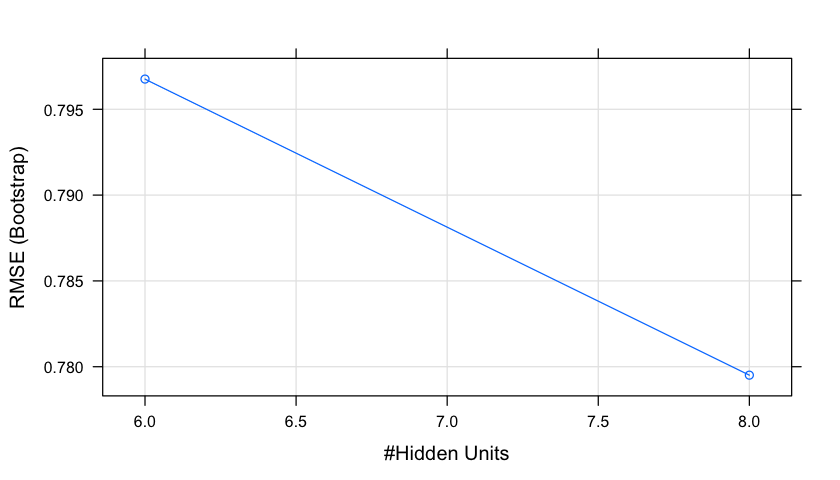

In [139]:
#testResults$avNNet = predict(avNNetTuneF, testXnnet)
plotsize(7,4)
plot(avNNetTuneF)

## Multivariate Adaptive Regression Splines

Splines are a flexible model to fit a nonlinear regression function ($E(Y|X)$).
MARS uses a collection of hockey-stick functions (hinge functions) to fit the response surface:
$$h(x) = x\, \mathbf{I}[x > 0]$$
The nodes for the individual hinge functions are actually $h(\mathbf{x} - \mathbf{c})$ (the points $\mathbf{c}$ where the hinge functions start increasing), must be estimated along with the coefficients
for how the $h(x)$ fit the regression function.

Multivariate Adaptive Regression Spline 

951 samples
228 predictors

No pre-processing
Resampling: Cross-Validated (4 fold) 
Summary of sample sizes: 714, 712, 713, 714 
Resampling results across tuning parameters:

  degree  nprune  RMSE       Rsquared 
  1        3      1.2032828  0.6508545
  1        9      0.8711956  0.8205688
  1       27      0.7200438  0.8791417
  1       81      0.7032375  0.8846252
  2        3      1.1146563  0.7049950
  2        9      0.8278346  0.8385735
  2       27      0.7332688  0.8743454
  2       81      0.7381761  0.8713007
  3        3      1.1138595  0.7056060
  3        9      0.8655595  0.8225751
  3       27      0.7478830  0.8727233
  3       81      0.7306112  0.8787719

RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were nprune = 81 and degree = 1.

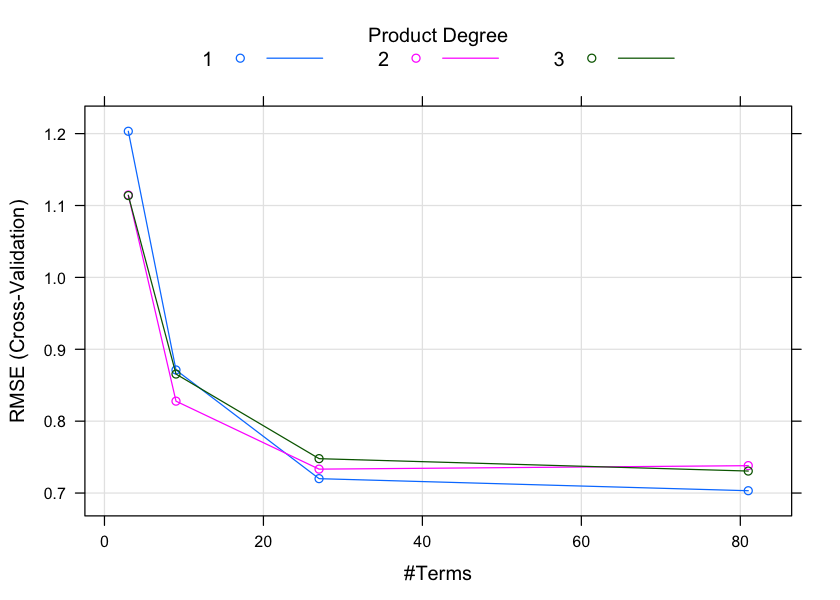

In [368]:
# (C) Kuhn and Johnson (2013)
################################################################################
### Section 7.2 Multivariate Adaptive Regression Splines

set.seed(100)
# first a wide sparse tuneGrid
marsTune0 <- train(x = solTrainXtrans, y = solTrainY,
                  method = "earth",
                  tuneGrid = expand.grid(degree = c(1,2,3), nprune = c(3,9,27,81)),
                  trControl = ctrl)

marsTune0
plot(marsTune0)

Multivariate Adaptive Regression Spline 

951 samples
228 predictors

No pre-processing
Resampling: Cross-Validated (4 fold) 
Summary of sample sizes: 714, 712, 713, 714 
Resampling results across tuning parameters:

  degree  nprune  RMSE       Rsquared 
  1        60     0.7032375  0.8846252
  1       120     0.7032375  0.8846252
  2        60     0.7381761  0.8713007
  2       120     0.7381761  0.8713007
  3        60     0.7306112  0.8787719
  3       120     0.7306112  0.8787719

RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were nprune = 60 and degree = 1.

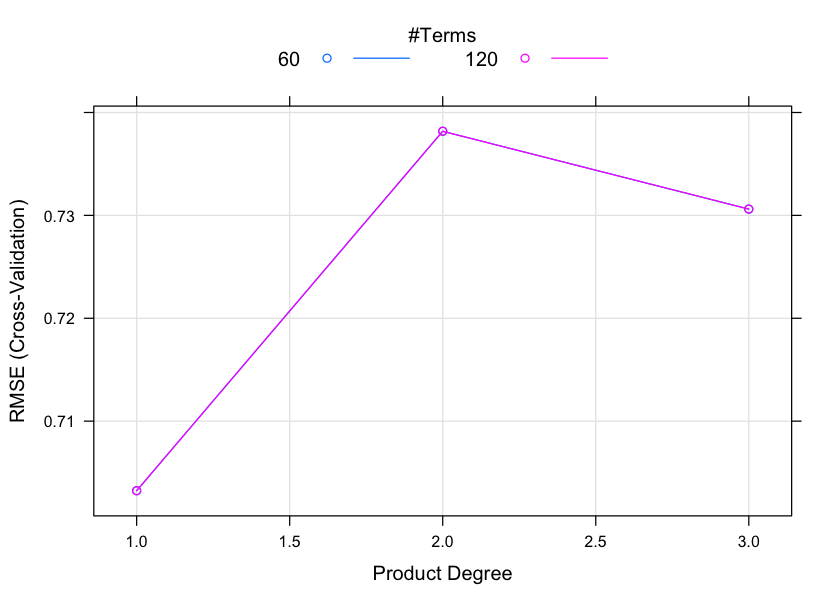

In [372]:
set.seed(100)
# expanding tuneGrid
marsTune1 <- train(x = solTrainXtrans, y = solTrainY,
                  method = "earth",
                  tuneGrid = expand.grid(degree = c(1,2,3), nprune = c(60,120)),
                  #tuneGrid = expand.grid(degree = c(1,2,3), nprune = round(30*c(1,1.25,1.25^2,1.25^3))),
                  trControl = ctrl)
marsTune1

plot(marsTune1)

In [379]:
set.seed(100)
# finer tuneGrid
tuneval <- expand.grid(nprune = 10*(3:9), degree = c(2,1,3))
tuneval = tuneval[c(1:8,10,12,16,19),]
t(tuneval)

1  2  3  4  5  6  7  8  10 12 16 19
nprune 30 40 50 60 70 80 90 30 50 70 40 70
degree  2  2  2  2  2  2  2  1  1  1  3  3

In [380]:
marsTune <- train(x = solTrainXtrans, y = solTrainY,
                  method = "earth",
                  tuneGrid = tuneval,
                  trControl = ctrl20)
marsTune
# takes two minutes (but worth it)

Multivariate Adaptive Regression Spline 

951 samples
228 predictors

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 903, 904, 903, 903, 904, 904, ... 
Resampling results across tuning parameters:

  degree  nprune  RMSE       Rsquared 
  1       30      0.7060970  0.8813708
  1       50      0.6919723  0.8859480
  1       70      0.6919723  0.8859480
  2       30      0.7141661  0.8791528
  2       40      0.7115677  0.8801405
  2       50      0.7115677  0.8801405
  2       60      0.7115677  0.8801405
  2       70      0.7115677  0.8801405
  2       80      0.7115677  0.8801405
  2       90      0.7115677  0.8801405
  3       40      0.6741254  0.8929622
  3       70      0.6743365  0.8927875

RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were nprune = 40 and degree = 3.

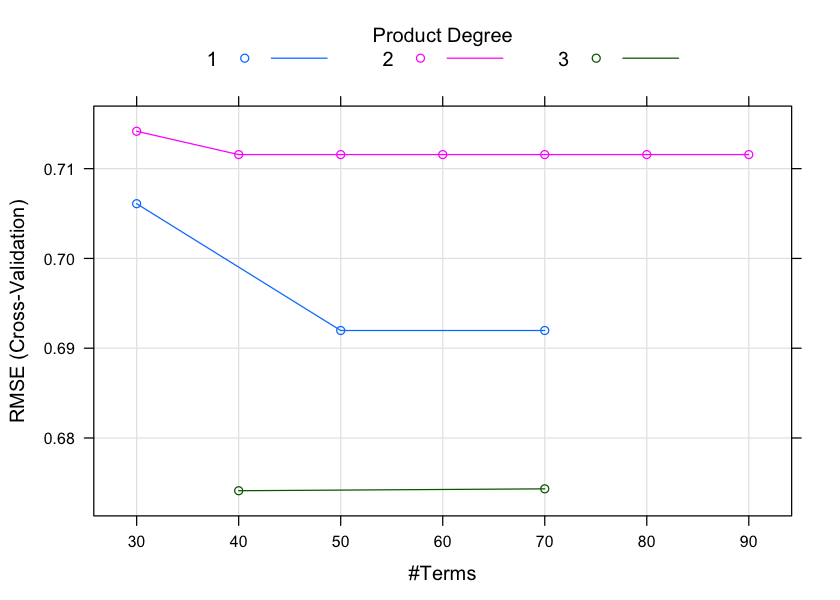

In [381]:
plot(marsTune)

In [382]:
summary(marsTune)

Call: earth(x=data.frame[951,228], y=c(-3.97,-3.98,-...), keepxy=TRUE,
            degree=3, nprune=40)

                                                                        coefficients
(Intercept)                                                               -6.9262283
FP059                                                                     -0.5332720
FP137                                                                      1.2140197
FP170                                                                      0.4306846
h(5.94458-MolWeight)                                                       5.7923163
h(2.99573-NumNonHAtoms)                                                    4.9812995
h(NumNonHAtoms-2.99573)                                                   -4.1380112
h(1.9554-SurfaceArea1)                                                    -0.1840880
h(SurfaceArea1-1.9554)                                                     0.2447441
FP043 * FP137                                

In [384]:
testResults$MARS <- predict(marsTune, solTestXtrans)
cor(testResults[,c(1,8:12)])

obs       Ridge     Enet      Enet2     NNet      MARS     
obs   1.0000000 0.9388013 0.9413624 0.9407979 0.9407308 0.9446675
Ridge 0.9388013 1.0000000 0.9963090 0.9973560 0.9866612 0.9673092
Enet  0.9413624 0.9963090 1.0000000 0.9996274 0.9875520 0.9701049
Enet2 0.9407979 0.9973560 0.9996274 1.0000000 0.9875379 0.9705076
NNet  0.9407308 0.9866612 0.9875520 0.9875379 1.0000000 0.9712741
MARS  0.9446675 0.9673092 0.9701049 0.9705076 0.9712741 1.0000000

The improvement from degree=3 seems to come out of nowhere. This is one of the problems with using a small number of folds, the data are more limited for each fold's predictions. The additional data are helpful in finding degree=3 effects which are obviously real due to the great test set results. To compare with 4-fold results:

Multivariate Adaptive Regression Spline 

951 samples
228 predictors

No pre-processing
Resampling: Cross-Validated (4 fold) 
Summary of sample sizes: 714, 712, 713, 714 
Resampling results across tuning parameters:

  degree  nprune  RMSE       Rsquared 
  1       30      0.7091055  0.8825701
  1       50      0.7032375  0.8846252
  1       70      0.7032375  0.8846252
  2       30      0.7289917  0.8744521
  2       40      0.7381761  0.8713007
  2       50      0.7381761  0.8713007
  2       60      0.7381761  0.8713007
  2       70      0.7381761  0.8713007
  2       80      0.7381761  0.8713007
  2       90      0.7381761  0.8713007
  3       40      0.7349071  0.8775626
  3       70      0.7306112  0.8787719

RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were nprune = 50 and degree = 1.

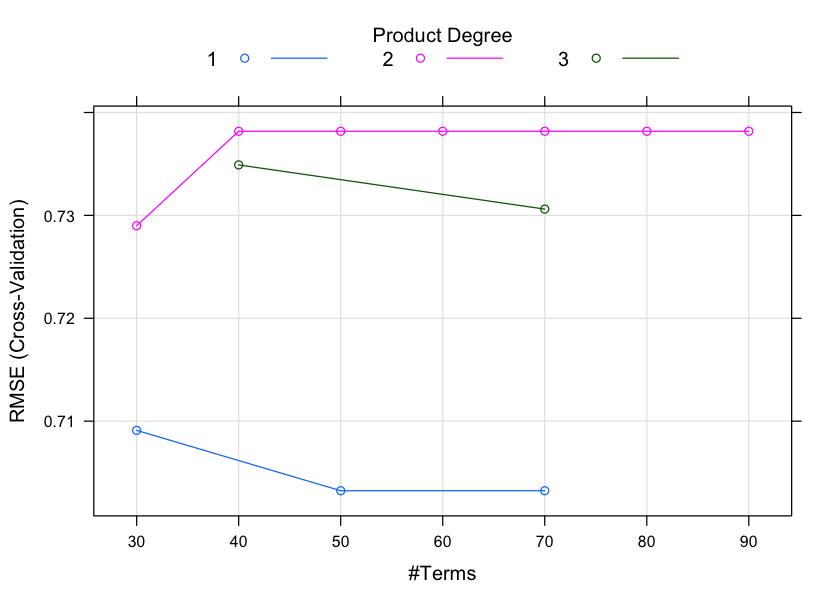

In [388]:
marsTune4Fold <- train(x = solTrainXtrans, y = solTrainY,
                  method = "earth",
                  tuneGrid = tuneval,
                  trControl = ctrl)
marsTune4Fold
# takes one minute
plot(marsTune4Fold)

An added bonus, predictor importance measures are available from the MARS fits:

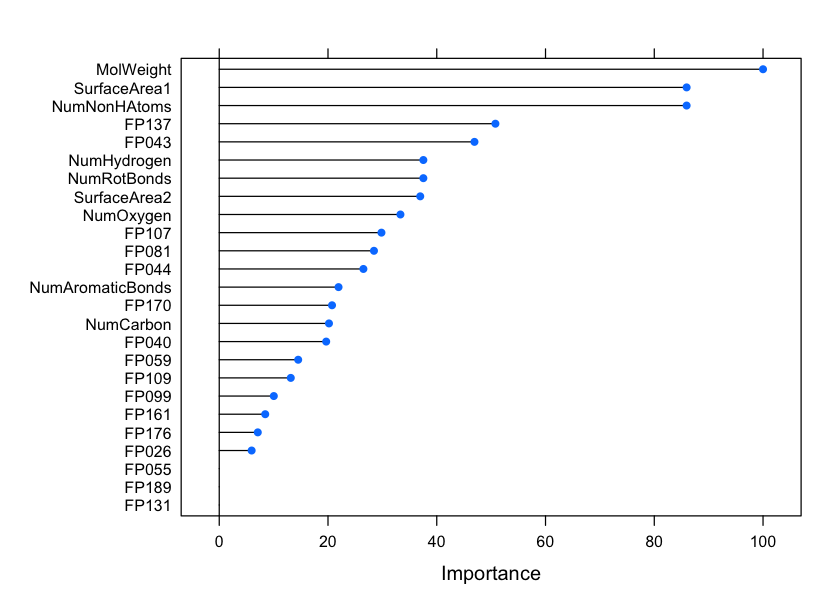

In [385]:
marsImp <- varImp(marsTune, scale = FALSE)
plotsize(7,5)
plot(marsImp, top = 25)

## Support Vector Machines

Just like neural networks, maybe more so, it is very important to tune SVMs and their many model parameters. Below a large sweep of cost values is shown over several orders of magnitude -- a good idea! SVM model parameters cover a large region unlike some methods.


In [386]:
# (C) Kuhn and Johnson (2013)
################################################################################
### Section 7.3 Support Vector Machines

## In a recent update to caret, the method to estimate the
## sigma parameter was slightly changed. These results will
## slightly differ from the text for that reason.

set.seed(100)
svmRTune <- train(x = solTrainXtrans, y = solTrainY,
                  method = "svmRadial",
                  preProc = c("center", "scale"),
                  tuneLength = 14,
                  trControl = ctrl)
svmRTune

Support Vector Machines with Radial Basis Function Kernel 

951 samples
228 predictors

Pre-processing: centered (228), scaled (228) 
Resampling: Cross-Validated (4 fold) 
Summary of sample sizes: 714, 712, 713, 714 
Resampling results across tuning parameters:

  C        RMSE       Rsquared 
     0.25  0.8516144  0.8527500
     0.50  0.7466833  0.8783793
     1.00  0.6929652  0.8908344
     2.00  0.6682661  0.8963082
     4.00  0.6606083  0.8978305
     8.00  0.6500999  0.9009305
    16.00  0.6457500  0.9020346
    32.00  0.6405546  0.9034572
    64.00  0.6374404  0.9043125
   128.00  0.6346527  0.9049878
   256.00  0.6356789  0.9046221
   512.00  0.6385039  0.9038120
  1024.00  0.6414556  0.9029918
  2048.00  0.6449199  0.9020963

Tuning parameter 'sigma' was held constant at a value of 0.002762998
RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were sigma = 0.002762998 and C = 128.

In [389]:
svmRTune$finalModel

Support Vector Machine object of class "ksvm" 

SV type: eps-svr  (regression) 
 parameter : epsilon = 0.1  cost C = 128 

Gaussian Radial Basis kernel function. 
 Hyperparameter : sigma =  0.00276299791797444 

Number of Support Vectors : 637 

Objective Function Value : -723.2202 
Training error : 0.009293 

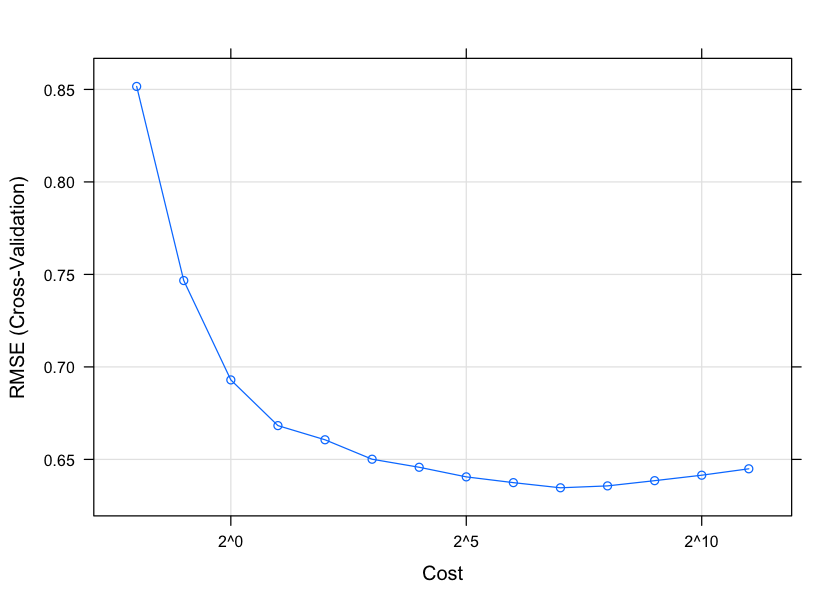

In [390]:
plot(svmRTune, scales = list(x = list(log = 2)))                 

In [169]:
# but can sigma be tuned in the radial basis kernel?
Rtuneval <- expand.grid(sigma = c(.0027, .0009, .0081), C = 5^(-1:4))

set.seed(100)
svmRTune1 <- train(x = solTrainXtrans, y = solTrainY,
                  method = "svmRadial",
                  preProc = c("center", "scale"),
                  tuneGrid = Rtuneval,
                  trControl = ctrl)
svmRTune1

Support Vector Machines with Radial Basis Function Kernel 

951 samples
228 predictors

Pre-processing: centered (228), scaled (228) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 856, 857, 855, 856, 856, 855, ... 
Resampling results across tuning parameters:

  sigma   C      RMSE       Rsquared 
  0.0009    0.2  1.0053957  0.8108242
  0.0009    1.0  0.7195838  0.8820746
  0.0009    5.0  0.6263986  0.9062942
  0.0009   25.0  0.6133773  0.9099953
  0.0009  125.0  0.6183704  0.9087862
  0.0009  625.0  0.6338237  0.9047233
  0.0027    0.2  0.8493628  0.8536611
  0.0027    1.0  0.6606906  0.8983515
  0.0027    5.0  0.6128332  0.9103894
  0.0027   25.0  0.5998045  0.9138249
  0.0027  125.0  0.5980350  0.9142175
  0.0027  625.0  0.5988361  0.9141228
  0.0081    0.2  0.9854832  0.8116332
  0.0081    1.0  0.7711909  0.8653243
  0.0081    5.0  0.7283495  0.8779307
  0.0081   25.0  0.7176235  0.8806729
  0.0081  125.0  0.7136537  0.8821503
  0.0081  625.0  0.7160022  0.8811837

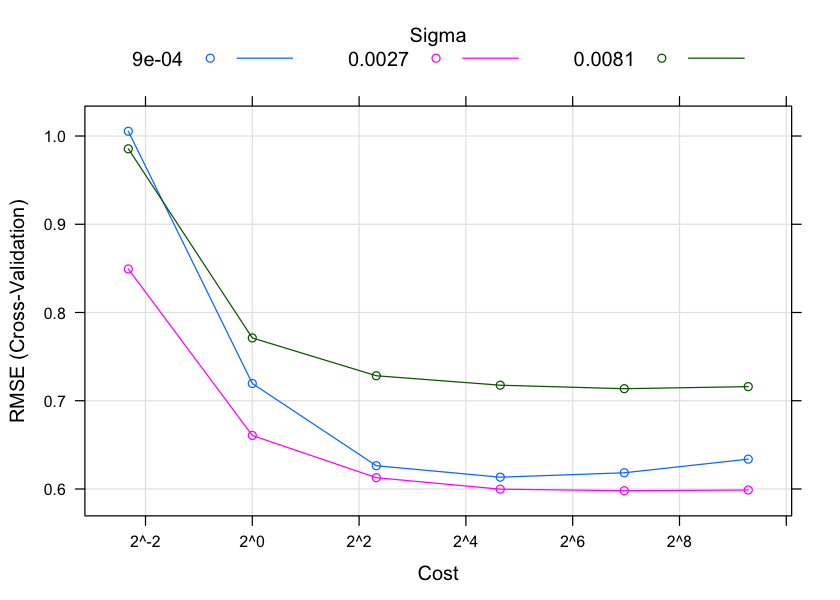

In [170]:
plot(svmRTune1, scales = list(x = list(log = 2)))  

Choice of sigma seems adequate, maybe I'd rerun with sigma = .002.

...But it's always good to know where the overfitting scale is for each parameter, and reducing sigma exposes us to overfitting the particulars in our training data, just like choosing $k=1$ in nearest neighbors is exposed to overfitting. That said, sigma = .0027 might be just right.

In [158]:
svmGrid <- expand.grid(degree = 1:2, 
                       scale = c(0.025, 0.005, 0.001), 
                       C = 10^(-1:2))
set.seed(100)
svmPTune <- train(x = solTrainXtrans, y = solTrainY,
                  method = "svmPoly",
                  preProc = c("center", "scale"),
                  tuneGrid = svmGrid,
                  trControl = ctrl)

svmPTune

Support Vector Machines with Polynomial Kernel 

951 samples
228 predictors

Pre-processing: centered (228), scaled (228) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 856, 857, 855, 856, 856, 855, ... 
Resampling results across tuning parameters:

  degree  scale  C      RMSE       Rsquared 
  1       0.001    0.1  1.3540284  0.7243821
  1       0.001    1.0  0.7925187  0.8582787
  1       0.001   10.0  0.6873021  0.8869297
  1       0.001  100.0  0.7283714  0.8737044
  1       0.005    0.1  0.8933684  0.8341428
  1       0.005    1.0  0.6935162  0.8853703
  1       0.005   10.0  0.7131621  0.8784904
  1       0.005  100.0  0.7379704  0.8704753
  1       0.025    0.1  0.7185737  0.8784253
  1       0.025    1.0  0.6984103  0.8832000
  1       0.025   10.0  0.7366633  0.8707496
  1       0.025  100.0  0.7422996  0.8694461
  2       0.001    0.1  1.1020197  0.7830031
  2       0.001    1.0  0.7008308  0.8854851
  2       0.001   10.0  0.6279474  0.9053654
  2       0.

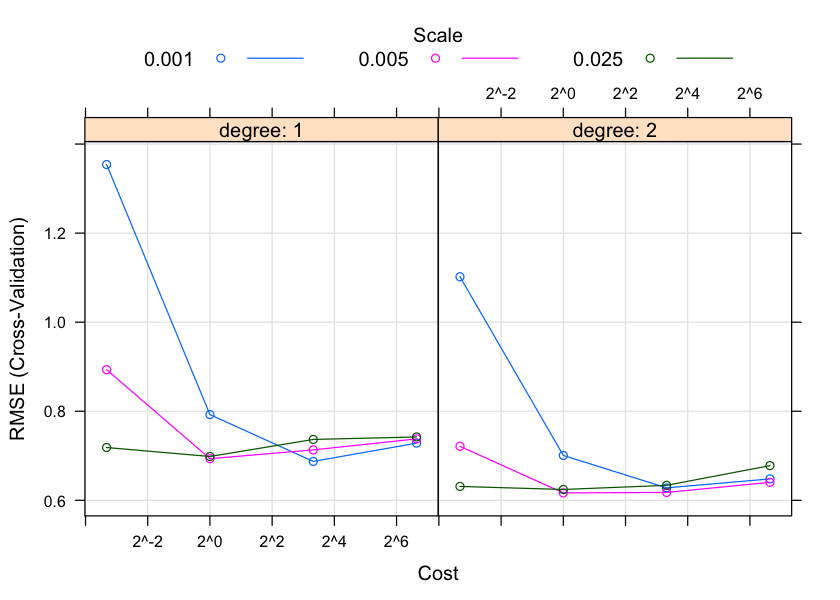

In [159]:
plot(svmPTune, 
     scales = list(x = list(log = 2), 
                   between = list(x = .5, y = 1)))                 

### Selecting tuning parameters

Which values for degree, scale, and cost did the program select? Are these the ones you would select?

- From above, we see that the scale parameter is very important. Set the cost too low for a given scale, and the RMSE rapidly increases.
- Choosing a larger scale helps reduce our exposure to mistakenly selecting a cost that's too low. We aren't sure how performance will be on the whole data, these are estimates based on our cross-validation results, so we have to have some "wiggle room" for the CV estimates being off.
- Choosing a scale of 0.025 may not achieve the lowest RMSE, but I like degree=2 scale=0.025 and cost=1 based on these CV results.
- Let's choose a finer scale and see if degree=3 will compute in a reasonable time. Based on the similarity between degree 1 and 2 results, we have some confidence in our parameters choices for degree=3 to estimate its performance 

In [166]:
svmGrid <- expand.grid( scale = c(0.02, 0.01), 
                       C = 4^(-1:1), degree = c(2,3))
svmGrid = svmGrid[c(1:6,9,12),]
# for degree 3: choosing C=4 with scale=0.01 (not too low) and C=1 with scale=0.02
svmGrid

scale C    degree
1  0.02  0.25 2     
2  0.01  0.25 2     
3  0.02  1.00 2     
4  0.01  1.00 2     
5  0.02  4.00 2     
6  0.01  4.00 2     
9  0.02  1.00 3     
12 0.01  4.00 3

In [167]:
set.seed(100)
svmPTune <- train(x = solTrainXtrans, y = solTrainY,
                  method = "svmPoly",
                  preProc = c("center", "scale"),
                  tuneGrid = svmGrid,
                  trControl = ctrl)

svmPTune

Support Vector Machines with Polynomial Kernel 

951 samples
228 predictors

Pre-processing: centered (228), scaled (228) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 856, 857, 855, 856, 856, 855, ... 
Resampling results across tuning parameters:

  scale  C     degree  RMSE       Rsquared 
  0.01   0.25  2       0.6209793  0.9075864
  0.01   1.00  2       0.6111335  0.9101010
  0.01   4.00  2       0.6121998  0.9100580
  0.01   4.00  3       0.6096875  0.9104752
  0.02   0.25  2       0.6211801  0.9068750
  0.02   1.00  2       0.6179583  0.9079720
  0.02   1.00  3       0.6436786  0.9011521
  0.02   4.00  2       0.6248520  0.9061891

RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were degree = 3, scale = 0.01 and C = 4.

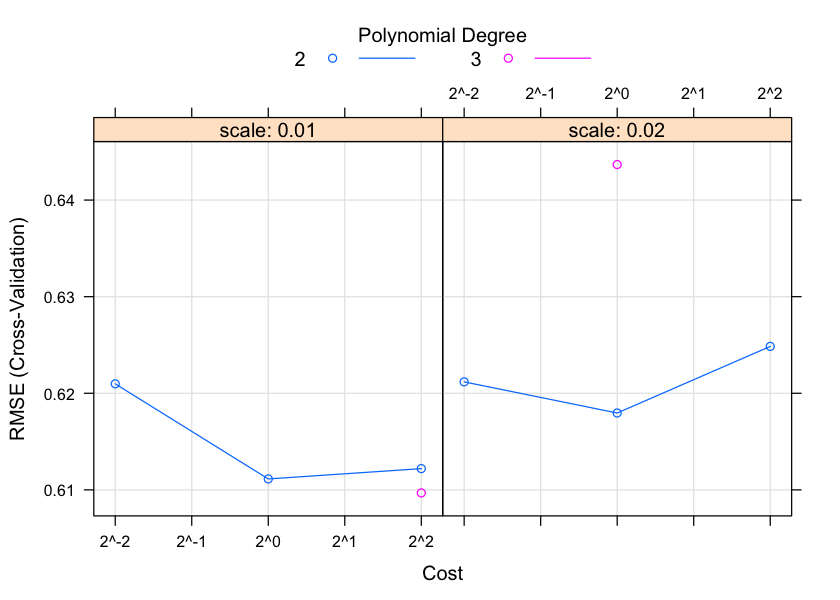

In [168]:
plot(svmPTune, 
     scales = list(x = list(log = 2), 
                   between = list(x = .5, y = 1)))         

Based on these CV results, I choose scale=0.01 (better than 0.005), Cost=2, degree=2 (not worth jumping the complexity to degree 3 for almost no benefit)

In [178]:
svmPreProc <- preProcess(solTrainXtrans, c("center","scale"))
solTrainXsvm <- predict(svmPreProc, solTrainXtrans)
solTestXsvm <- predict(svmPreProc, solTestXtrans)

In [179]:
set.seed(100)
svmPTuneF <- svm(x = solTrainXsvm, y = solTrainY,
                   C=2, degree=2, scale=0.01, kernel="polynomial",
                  preProc = c("center", "scale"))
svmPTuneF

Warning message in any(scale):
“coercing argument of type 'double' to logical”Warning message in any(object$scaled):
“coercing argument of type 'double' to logical”Warning message in any(object$scaled):
“coercing argument of type 'double' to logical”


Call:
svm.default(x = solTrainXsvm, y = solTrainY, scale = 0.01, kernel = "polynomial", 
    degree = 2, C = 2, preProc = c("center", "scale"))


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  polynomial 
       cost:  1 
     degree:  2 
      gamma:  0.004385965 
     coef.0:  0 
    epsilon:  0.1 


Number of Support Vectors:  722


In [200]:
testResults$SVMr <- predict(svmRTune, solTestXtrans)
testResults$SVMp <- predict(svmPTuneF, solTestXsvm)

Warning message in any(object$scaled):
“coercing argument of type 'double' to logical”Warning message in any(object$scaled):
“coercing argument of type 'double' to logical”

## K-Nearest Neighbors

In [192]:
# (C) Kuhn and Johnson (2013)
################################################################################
### Section 7.4 K-Nearest Neighbors

### First we remove near-zero variance predictors
knnDescr <- solTrainXtrans[, -nearZeroVar(solTrainXtrans)]

set.seed(100)
knnTune <- train(x = knnDescr, y = solTrainY,
                 method = "knn",
                 preProc = c("center", "scale"),
                 tuneGrid = data.frame(k = 1:20),
                 trControl = ctrl)
knnTune
testResults$Knn <- predict(knnTune, solTestXtrans[, names(knnDescr)])

k-Nearest Neighbors 

951 samples
225 predictors

Pre-processing: centered (225), scaled (225) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 856, 857, 855, 856, 856, 855, ... 
Resampling results across tuning parameters:

  k   RMSE      Rsquared 
   1  1.229745  0.6710823
   2  1.102057  0.7233931
   3  1.057972  0.7407611
   4  1.041420  0.7465429
   5  1.056222  0.7377971
   6  1.051150  0.7391613
   7  1.052694  0.7388048
   8  1.045468  0.7420267
   9  1.054200  0.7375261
  10  1.060630  0.7348148
  11  1.064501  0.7332010
  12  1.076157  0.7270332
  13  1.084877  0.7226715
  14  1.089678  0.7201092
  15  1.098308  0.7153520
  16  1.107097  0.7108917
  17  1.114296  0.7075958
  18  1.122538  0.7037828
  19  1.129979  0.7002080
  20  1.136227  0.6970077

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was k = 4.

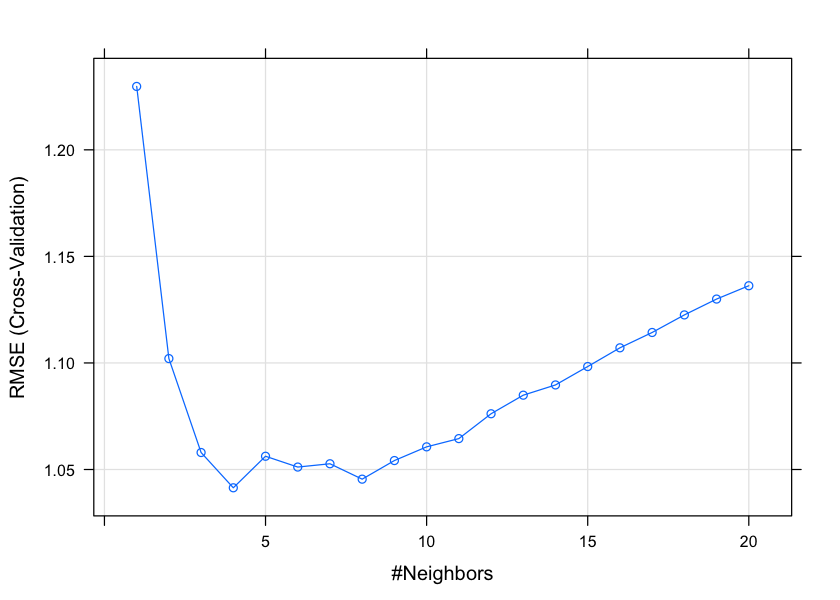

In [185]:
plot(knnTune)

In [193]:
# I'd use k=8 based on those CV results
set.seed(100)
indx50 <- createFolds(solTrainY, returnTrain = TRUE, k=50)
ctrl50 <- trainControl(method = "cv", index = indx50)

set.seed(100)
knnTuneF <- train(x = knnDescr, y = solTrainY,
                 method = "knn",
                 preProc = c("center", "scale"),
                 tuneGrid = data.frame(k = 6:10),
                 trControl = ctrl50)
knnTuneF

k-Nearest Neighbors 

951 samples
225 predictors

Pre-processing: centered (225), scaled (225) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 932, 934, 931, 935, 931, 932, ... 
Resampling results across tuning parameters:

  k   RMSE      Rsquared 
   6  1.037070  0.7356350
   7  1.043405  0.7338611
   8  1.025509  0.7411777
   9  1.038036  0.7377512
  10  1.045266  0.7335877

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was k = 8.

In [191]:
dim(knnDescr)
head(knnDescr)
nearZeroVar(solTrainXtrans)
dim(solTestXtrans)

[1] 951 225

FP001 FP002 FP003 FP004 FP005 FP006 FP007 FP008 FP009 FP010 ⋯ NumCarbon
661 0     1     0     0     1     0     0     1     0     0     ⋯ 4.177811 
662 0     1     0     1     1     1     1     1     0     0     ⋯ 5.092358 
663 1     1     1     1     1     0     0     1     0     1     ⋯ 4.023944 
665 0     0     1     0     0     0     1     0     0     0     ⋯ 3.510455 
668 0     0     1     1     1     1     0     0     1     0     ⋯ 3.317541 
669 1     0     1     1     0     0     0     0     1     0     ⋯ 3.510455 
    NumNitrogen NumOxygen NumSulfer NumChlorine NumHalogen NumRings 
661 0.5848146   0.0000000 0.000     0.0000000   0.0000000  1.3862944
662 0.6423550   0.6931472 0.375     0.0000000   0.0000000  1.6094379
663 0.0000000   1.0986123 0.000     0.0000000   0.0000000  0.6931472
665 0.0000000   0.0000000 0.000     0.0000000   0.0000000  0.6931472
668 0.6943345   0.0000000 0.000     0.3750000   0.3750000  0.6931472
669 0.4568260   0.6931472 0.375     0.4444444   0.4444444  0.0000000
    HydrophilicFactor SurfaceArea1 SurfaceArea2
661 -1.60654181       6.812456      6.812456   
662 -0.44133043       9.753834     12.029604   
663 -0.38485910       8.245324      8.245324   
665 -2.37347220       0.000000      0.000000   
668 -0.07098726       9.913535      9.913535   
669 -0.94925327       5.999109      9.123359

[1] 154 199 200

[1] 316 228

In [195]:
testResults$Knn <- predict(knnTuneF, solTestXtrans[, names(knnDescr)])

## Summary of nonlinear regression methods

In [202]:
cat("Training Errors:\n")
fullpred <- predict(enetTune, solTrainXtrans)
cat('Enet:  ',1 - sum((fullpred - solTrainY)^2) / sum((solTrainY - mean(solTrainY))^2),": ")
fullpred <- predict(nnetTune, solTrainXtrans)
cat('NNet:  ',1 - sum((fullpred - solTrainY)^2) / sum((solTrainY - mean(solTrainY))^2),": ")
fullpred <- predict(avNNetTuneF, trainXnnet)
cat('avNNet:',1 - sum((fullpred - solTrainY)^2) / sum((solTrainY - mean(solTrainY))^2),":\n")
fullpred <- predict(marsTune, solTrainXtrans)
cat('MARS:  ',1 - sum((fullpred - solTrainY)^2) / sum((solTrainY - mean(solTrainY))^2),": ")
fullpred <- predict(svmRTune, solTrainXtrans)
cat('SVMr:  ',1 - sum((fullpred - solTrainY)^2) / sum((solTrainY - mean(solTrainY))^2)," : ")
fullpred <- predict(svmPTune, solTrainXtrans)
cat('SVMp:  ',1 - sum((fullpred - solTrainY)^2) / sum((solTrainY - mean(solTrainY))^2),": ")
fullpred <- predict(knnTuneF, solTrainXtrans)
cat('kNN:   ',1 - sum((fullpred - solTrainY)^2) / sum((solTrainY - mean(solTrainY))^2),"\n")
cat("Testing Errors:\n") 
fullpred <- predict(enetTune, solTestXtrans)
cat('Enet:  ',1 - sum((fullpred - solTestY)^2) / sum((solTestY - mean(solTestY))^2)," : ")
fullpred <- predict(nnetTune, solTestXtrans)
cat('NNet:  ',1 - sum((fullpred - solTestY)^2) / sum((solTestY - mean(solTestY))^2),": ")
fullpred <- predict(avNNetTuneF, testXnnet)
cat('avNNet:',1 - sum((fullpred - solTestY)^2) / sum((solTestY - mean(solTestY))^2),":\n")
fullpred <- predict(marsTune, solTestXtrans)
cat('MARS:  ',1 - sum((fullpred - solTestY)^2) / sum((solTestY - mean(solTestY))^2),": ")
fullpred <- predict(svmRTune, solTestXtrans)
cat('SVMr:  ',1 - sum((fullpred - solTestY)^2) / sum((solTestY - mean(solTestY))^2),": ")
fullpred <- predict(svmPTune, solTestXtrans)
cat('SVMp:  ',1 - sum((fullpred - solTestY)^2) / sum((solTestY - mean(solTestY))^2),": ")
fullpred <- testResults$Knn
cat('kNN:  ',1 - sum((fullpred - solTestY)^2) / sum((solTestY - mean(solTestY))^2),"\n")


Training Errors:
Enet:   0.9227276 : NNet:   0.9754285 : avNNet: 0.9688247 :
MARS:   0.9189357 : SVMr:   0.9907156  : SVMp:   0.9907598 : kNN:    0.7963496 
Testing Errors:
Enet:   0.885803  : NNet:   0.8863654 : avNNet: 0.8607299 :
MARS:   0.8786158 : SVMr:   0.9144164 : SVMp:   0.9111115 : kNN:   0.7349325 


In [203]:
# I will ignore the additional tuning for SVMp (didn't work)
testResults$SVMp <- predict(svmPTune, solTestXtrans)

In [204]:
temp <- sapply(2:ncol(testResults), 
       function(k){
           sqrt(sum((testResults$obs - testResults[,k])^2)/nrow(testResults))})
names(temp) <- colnames(testResults)[2:ncol(testResults)]
temp

Linear_Regression               PLS              step               RLM 
        0.7587330         0.7205682         0.8769585         0.7869804 
              PCR             Ridge              Enet              NNet 
        0.7909240         0.7193079         0.7012669         0.6995380 
           avNNet              MARS              SVMr              SVMp 
        0.7744350         0.7229979         0.6070873         0.6186980 
              Knn 
        1.0684007